### QUANT627 - Financial Econometrics Midterm
*Author: Augustin Valery, Leopold Dessane, Arthur Polini*

--------------------------------------------------------------------<br>
Name and exact ticker : The Walt Disney Company - DIS<br>
Length of the sample : 15857 trading days, 756 months , 63 years<br>
Initial date : 02/01/1962<br>
Final date : 30/12/2024<br>
Stock Market : New York Stock Exchange<br>
Country : United States<br>
--------------------------------------------------------------------<br>

In [223]:
# Install Yahoo Finance and Statsmodels libraries
%pip install yfinance statsmodels powerlaw arch pandas_datareader


Note: you may need to restart the kernel to use updated packages.


In [224]:
# Import repository (packages/libraries/modules)
import pandas as pd 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from scipy.stats import gaussian_kde, norm, iqr, skew, kurtosis, jarque_bera, kstest, anderson, shapiro, linregress
import scipy.signal as ss
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests
from statsmodels.stats.diagnostic import lilliefors, acorr_ljungbox, het_white, acorr_breusch_godfrey, linear_reset
from statsmodels.stats.stattools import durbin_watson
from statsmodels.iolib.summary2 import summary_col
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import powerlaw as pwl
from arch import arch_model

### Part I - Stylzed Facts on Prices and Returns

##### Load data and transformation

*Note: 31st of December is bank holiday for NYSE*

In [225]:
# Define ticker
TICKER = "DIS"

# Retreiving data from Yahoo Finance
DIS = yf.download(TICKER, start="1951-12-31", end="2024-12-31", auto_adjust=False)

DIS.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,DIS,DIS,DIS,DIS,DIS,DIS
Date,,,,,,
1962-01-02,0.057441,0.092908,0.096026,0.092908,0.092908,841958
1962-01-03,0.058212,0.094155,0.094467,0.092908,0.092908,801865
1962-01-04,0.058212,0.094155,0.094467,0.093532,0.094155,962238
1962-01-05,0.058405,0.094467,0.094779,0.093844,0.094155,962238
1962-01-08,0.058212,0.094155,0.095714,0.092285,0.094467,1282984


In [226]:
# Compute daily adjusted closing prices
Pt_daily_all = DIS["Adj Close"]
Pt_daily_all = Pt_daily_all.rename(columns={Pt_daily_all.columns[0]: "Pt.d"})
Pt_daily_all.set_index(pd.to_datetime(Pt_daily_all.index))

# Compute closing log prices
pt_daily_all = np.log(Pt_daily_all["Pt.d"])
pt_weekly_all = pt_daily_all.resample('W').last()
pt_monthly_all = pt_daily_all.resample('ME').last()
pt_yearly_all = pt_daily_all.resample('YE').last()
# Rename series
pt_daily_all.name, pt_weekly_all.name, pt_monthly_all.name, pt_yearly_all.name = "pt.d.all", "pt.w.all", "pt.m.all", "pt.y.all"

pt_daily_all.head()

Date
1962-01-02   -2.856999
1962-01-03   -2.843666
1962-01-04   -2.843666
1962-01-05   -2.840359
1962-01-08   -2.843666
Name: pt.d.all, dtype: float64

In [227]:
# Compute log returns
rt_daily_all = pt_daily_all.diff().dropna()
rt_weekly_all = pt_weekly_all.diff().dropna()
rt_monthly_all = pt_monthly_all.diff().dropna()
rt_yearly_all = pt_yearly_all.diff().dropna()
# Rename series
rt_daily_all.name, rt_weekly_all.name, rt_monthly_all.name, rt_yearly_all.name = "rt.d.all", "rt.w.all", "rt.m.all", "rt.y.all"

rt_daily_all.head()

Date
1962-01-03    0.013333
1962-01-04    0.000000
1962-01-05    0.003308
1962-01-08   -0.003308
1962-01-09    0.019676
Name: rt.d.all, dtype: float64

In [228]:
# Define sample interval
ts_start_date = pd.to_datetime('1961-01-02')
ts_end_date = pd.to_datetime('2024-12-31')

# Select the interval on the time series
Pt_daily = Pt_daily_all.loc[ts_start_date:ts_end_date]
pt_daily = pt_daily_all.loc[ts_start_date:ts_end_date]
pt_weekly = pt_weekly_all.loc[ts_start_date:ts_end_date]
pt_montly = pt_monthly_all.loc[ts_start_date:ts_end_date]
rt_daily = rt_daily_all.loc[ts_start_date:ts_end_date]
rt_weekly = rt_weekly_all.loc[ts_start_date:ts_end_date]
rt_monthly = rt_monthly_all.loc[ts_start_date:ts_end_date]
rt_yearly = rt_yearly_all.loc[ts_start_date:ts_end_date]

rt_daily.head()


Date
1962-01-03    0.013333
1962-01-04    0.000000
1962-01-05    0.003308
1962-01-08   -0.003308
1962-01-09    0.019676
Name: rt.d.all, dtype: float64

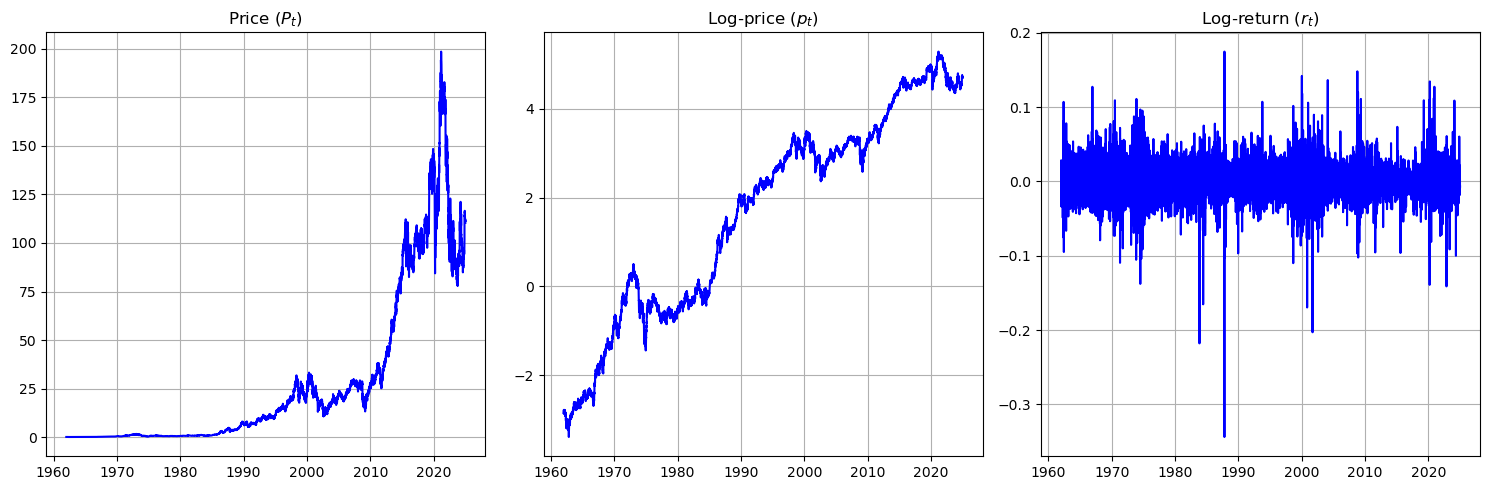

In [229]:
# Create a plot summary of the prices and returns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Daily prices
axs[0].plot(Pt_daily.index, Pt_daily, color='blue')
axs[0].set_title('Price ($P_t$)')
axs[0].grid(True)
# Daily log prices
axs[1].plot(pt_daily.index, pt_daily, color='blue')
axs[1].set_title('Log-price ($p_t$)')
axs[1].grid(True)
# Daily log-returns
axs[2].plot(rt_daily.index, rt_daily, color='blue')
axs[2].set_title('Log-return ($r_t$)')
axs[2].grid(True)

# Adjust layout and plot
plt.tight_layout()
plt.show()

In [230]:
# Create descriptive table

# Define log returns sources
rt = {
    "Daily": rt_daily,
    "Weekly": rt_weekly,
    "Monthly": rt_monthly,
    "Annual": rt_yearly
}

# Create statistics computation function
def statistics_A(x):
    stat_tab = {
        'Mean': round(np.mean(x) * 100,5),
        'St.Deviation': round(np.std(x) * 100,5),
        'Diameter.C.I.Mean': round(1.96 * np.sqrt(np.var(x) / len(x)) * 100,5),
        'Skewness': round(skew(x),5),
        'Kurtosis': round(kurtosis(x),5),
        'Excess.Kurtosis': round(kurtosis(x) - 3,5),
        'Min': round(np.min(x) * 100,5),
        'Quant.5%': round(np.quantile(x, 0.05) * 100,5),
        'Quant.25%': round(np.quantile(x, 0.25) * 100,5),
        'Median': round(np.quantile(x, 0.50) * 100,5),
        'Quant.75%': round(np.quantile(x, 0.75) * 100,5),
        'Quant.95%': round(np.quantile(x, 0.95) * 100,5),
        'Max': round(np.max(x) * 100,5),
        'Jarque.Bera.stat': round(jarque_bera(x)[0],5),
        'Jarque.Bera.pvalue.X100': round(jarque_bera(x)[1] *100,5),
        'Lillie.test.stat': round(lilliefors(x)[0],5),
        'Lillie.test.pvalue.X100': round(lilliefors(x)[1] * 100,5),
        'N.obs': len(x)
    }
    return stat_tab

STATS_R = pd.DataFrame({key: statistics_A(data) for key, data in rt.items()})

STATS_R

,Daily,Weekly,Monthly,Annual
Mean,0.04768,0.22978,1.00050,12.57913
St.Deviation,1.98466,4.24504,8.89712,31.13979
Diameter.C.I.Mean,0.03089,0.14515,0.63465,7.75132
Skewness,-0.38827,-0.24040,-0.46307,-0.83356
Kurtosis,12.31758,3.18203,2.67150,1.87467
Excess.Kurtosis,9.31758,0.18203,-0.32850,-1.12533
Min,-34.38205,-27.72754,-47.67273,-91.84056
Quant.5%,-2.90381,-6.20483,-13.41538,-33.69372
Quant.25%,-0.95996,-2.14481,-3.97382,-0.36462
Median,0.00000,0.18658,1.36321,14.01992


#### Stylized Fact 1: Prices are non-stationary

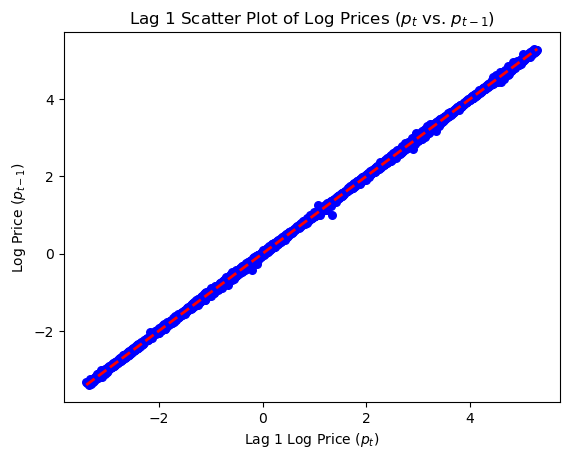

In [231]:
# TEST 1: Lag-1 scatter plot of log-returns

# Define lagged time series
pt_daily_lag1 = pt_daily.shift(1)

# Define the lag1_scatterplot function
plt.scatter(pt_daily_lag1, pt_daily, color='blue', s=30)
plt.plot([min(pt_daily), max(pt_daily)], [min(pt_daily), max(pt_daily)], linestyle='dashed', linewidth=2, color='red') 
plt.xlabel("Lag 1 Log Price ($p_t$)")
plt.ylabel("Log Price ($p_{t-1}$)")
plt.title("Lag 1 Scatter Plot of Log Prices ($p_t$ vs. $p_{t-1}$)")
plt.show()

In [232]:
# TEST 2: Augmented Dickey-Fuller (ADF) test

# Test results
adf_result = adfuller(pt_daily)
ADF = pd.Series({
    "ADF": adf_result[0],
    "p-value": adf_result[1],
    "Critical Value (1%)": adf_result[4]['1%'],
    "Critical Value (5%)": adf_result[4]['5%'],
    "Critical Value (10%)": adf_result[4]['10%']
})

print(f"H0: δ = 0 (unit root, non-stationary)\nH1: δ < 0 (no unit root, stationary)\n-----\n{ADF}\n-----")

if ADF["p-value"] > 0.05 and ADF["ADF"] > ADF["Critical Value (10%)"]:
    print("Fail to reject the null hypothesis, the time series is likely non-stationary.")
else : 
    print("Reject the null hypothesis, the time series is likely stationary.")

H0: δ = 0 (unit root, non-stationary)
H1: δ < 0 (no unit root, stationary)
-----
ADF                    -1.477324
p-value                 0.544698
Critical Value (1%)    -3.430763
Critical Value (5%)    -2.861722
Critical Value (10%)   -2.566867
dtype: float64
-----
Fail to reject the null hypothesis, the time series is likely non-stationary.


In [233]:
# TEST 3: Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

kpss_results = kpss(pt_daily, regression='c')
print(kpss_results)

KPSS = pd.Series({
    "KPSS": kpss_results[0],
    "p-value": kpss_results[1],
    "Critical Value (1%)": kpss_results[3]['1%'],
    "Critical Value (5%)": kpss_results[3]['5%'],
    "Critical Value (10%)": kpss_results[3]['10%']
})

print(f"H0: Var(u) = 0 (no white noise, stationary)\nH1: Var(u) > 0 (white noise, non stationary)\n-----\n{KPSS}\n-----")

if KPSS["p-value"] > 0.05 and KPSS["KPSS"] < KPSS["Critical Value (10%)"]:
    print("Fail to reject the null hypothesis, the time series is likely stationary.")
else : 
    print("Reject the null hypothesis, the time series is likely non-stationary.")

(np.float64(19.95824957303601), np.float64(0.01), 75, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
H0: Var(u) = 0 (no white noise, stationary)
H1: Var(u) > 0 (white noise, non stationary)
-----
KPSS                    19.95825
p-value                  0.01000
Critical Value (1%)      0.73900
Critical Value (5%)      0.46300
Critical Value (10%)     0.34700
dtype: float64
-----
Reject the null hypothesis, the time series is likely non-stationary.


/var/folders/z6/j_nqb41d7p71wfmbz0m97p200000gn/T/ipykernel_5398/164833884.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_results = kpss(pt_daily, regression='c')


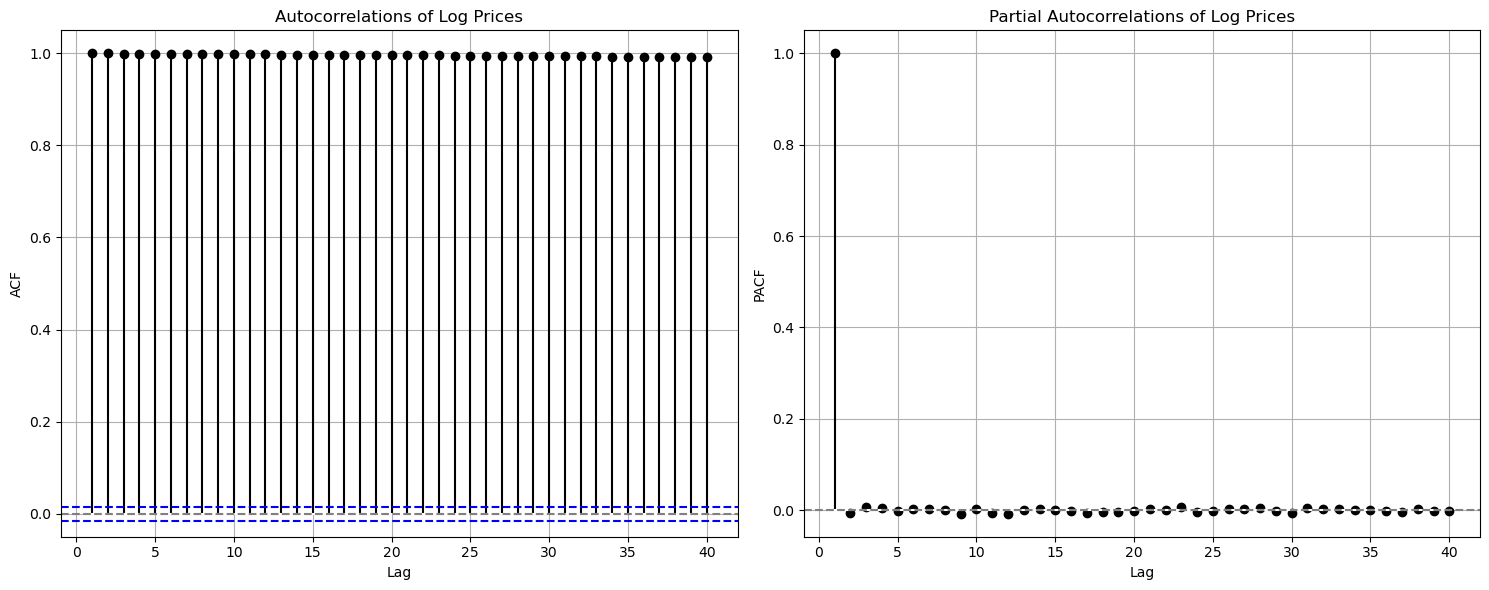

In [234]:
# TEST 4: Autocorrelation function and Partial Autocorrelation Function
lags = 40
conf_value = 1.96
acf_values = acf(pt_daily, nlags=lags)
pacf_values = pacf(pt_daily, nlags=lags)

#Bartlett intervals for ACF
bartlett = conf_value / np.sqrt(len(pt_daily))

fig, axs = plt.subplots(1, 2, figsize=(15, 6)) 

# ACF (Autocorrelation Function)
axs[0].stem(np.arange(1, lags + 1), acf_values[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[0].axhline(y=0, color='gray', linestyle='--')
axs[0].axhline(y=bartlett, color='blue', linestyle='--')
axs[0].axhline(y=-bartlett, color='blue', linestyle='--')
axs[0].set_title('Autocorrelations of Log Prices')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
axs[0].grid(True)

# PACF (Partial Autocorrelation Function)
axs[1].stem(np.arange(1, lags + 1), pacf_values[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[1].axhline(y=0, color='gray', linestyle='--')
axs[1].set_title('Partial Autocorrelations of Log Prices')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF')
axs[1].grid(True)

plt.tight_layout()
plt.show()

#### Stylized Fact 2: Returns are stationary

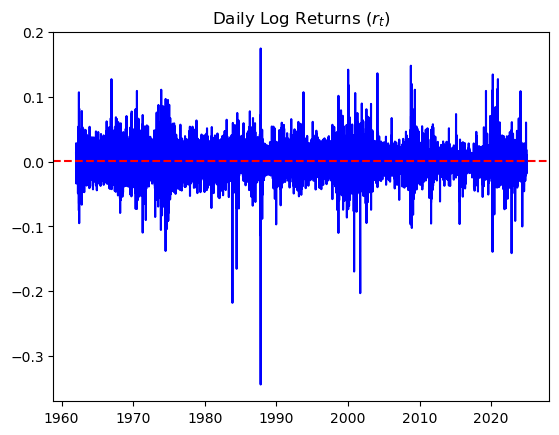

In [235]:
# TEST 1: Lag-1 scatter plot of log-returns

plt.plot(rt_daily, color='blue')
plt.axhline(y=rt_daily.mean(), color="red",linestyle='dashed', linewidth=1.5)
plt.title("Daily Log Returns ($r_t$)")
plt.show()

In [236]:
# TEST 2: Augmented Dickey-Fuller (ADF) test

# Test results
adf_result = adfuller(rt_daily)
ADF = pd.Series({
    "ADF": adf_result[0],
    "p-value": adf_result[1],
    "Critical Value (1%)": adf_result[4]['1%'],
    "Critical Value (5%)": adf_result[4]['5%'],
    "Critical Value (10%)": adf_result[4]['10%']
})

print(f"H0: δ = 0 (unit root, non-stationary)\nH0: δ < 0 (no unit root, stationary)\n-----\n{ADF}\n-----")

if ADF["p-value"] > 0.05 and ADF["ADF"] > ADF["Critical Value (10%)"]:
    print("Fail to reject the null hypothesis, the time series is likely non-stationary.")
else : 
    print("Reject the null hypothesis, the time series is likely stationary.")

H0: δ = 0 (unit root, non-stationary)
H0: δ < 0 (no unit root, stationary)
-----
ADF                    -74.819334
p-value                  0.000000
Critical Value (1%)     -3.430763
Critical Value (5%)     -2.861722
Critical Value (10%)    -2.566867
dtype: float64
-----
Reject the null hypothesis, the time series is likely stationary.


In [237]:
# TEST 3: Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

kpss_results = kpss(rt_daily, regression='c')

KPSS = pd.Series({
    "KPSS": kpss_results[0],
    "p-value": kpss_results[1],
    "Critical Value (1%)": kpss_results[3]['1%'],
    "Critical Value (5%)": kpss_results[3]['5%'],
    "Critical Value (10%)": kpss_results[3]['10%']
})

print(f"H0: Var(u) = 0 (no white noise, stationary)\nH1: Var(u) > 0 (white noise, non stationary)\n-----\n{KPSS}\n-----")

if KPSS["p-value"] > 0.05 and KPSS["KPSS"] < KPSS["Critical Value (10%)"]:
    print("Fail to reject the null hypothesis, the time series is likely stationary.")
else : 
    print("Reject the null hypothesis, the time series is likely non-stationary.")

H0: Var(u) = 0 (no white noise, stationary)
H1: Var(u) > 0 (white noise, non stationary)
-----
KPSS                    0.129965
p-value                 0.100000
Critical Value (1%)     0.739000
Critical Value (5%)     0.463000
Critical Value (10%)    0.347000
dtype: float64
-----
Fail to reject the null hypothesis, the time series is likely stationary.


/var/folders/z6/j_nqb41d7p71wfmbz0m97p200000gn/T/ipykernel_5398/2193240906.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_results = kpss(rt_daily, regression='c')


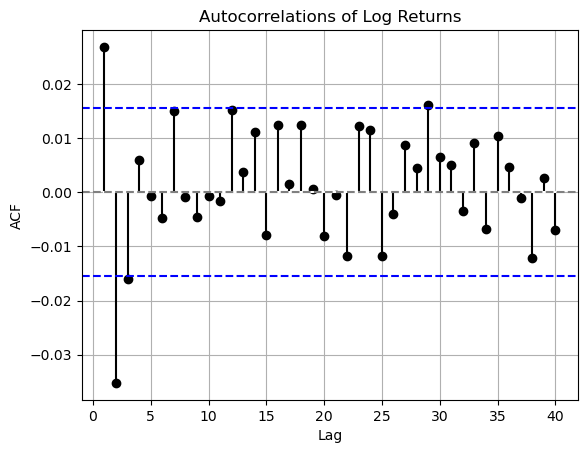

In [238]:
# TEST 4: Autocorrelation function
lags = 40
conf_value = 1.96
acf_values = acf(rt_daily, nlags=lags)

#Bartlett intervals for ACF
bartlett = conf_value / np.sqrt(len(rt_daily))

# ACF (Autocorrelation Function)
plt.stem(np.arange(1, lags + 1), acf_values[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=bartlett, color='blue', linestyle='--')
plt.axhline(y=-bartlett, color='blue', linestyle='--')
plt.title('Autocorrelations of Log Returns')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)

plt.show()

#### Stylized Fact 3: Returns are asymmetric (negative skewness)


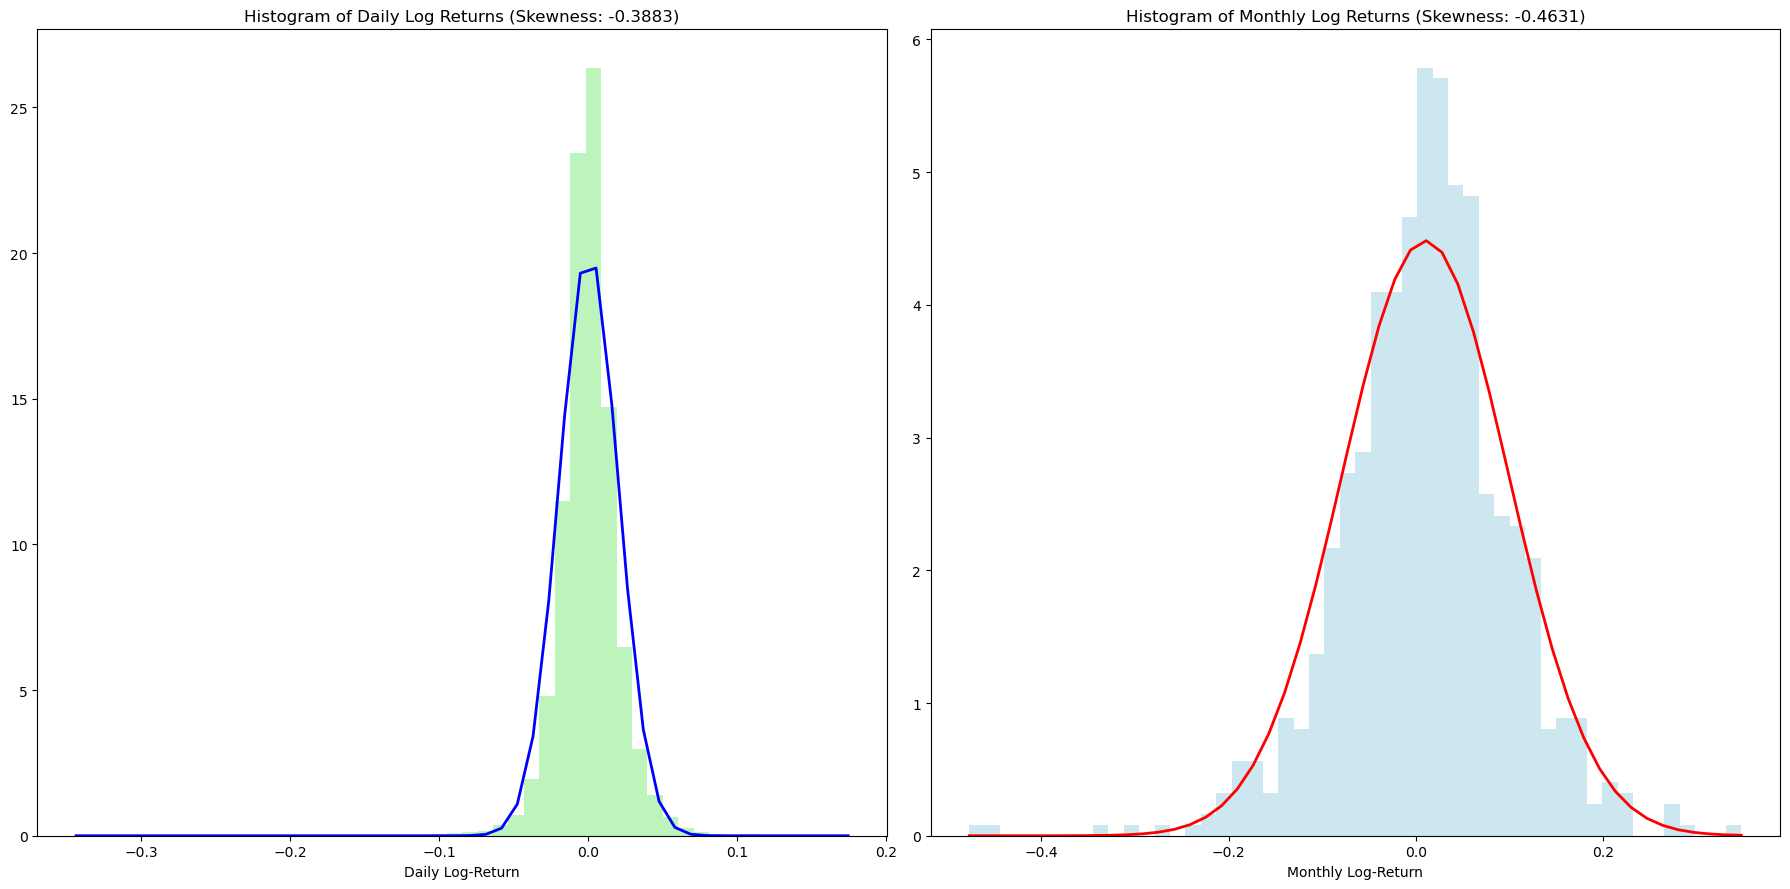

Daily log returns skewness: -0.3882690870874816
Monthly log returns skewness: -0.4630698961103791


In [239]:
# TEST 1: Histogram and skewness versus normal distribution

# Skewness computation
skew_daily = skew(rt_daily) ### REMPLACER PAR la valeur calculé dans le tableau descriptif
skew_monthly = skew(rt_monthly) ### REMPLACER PAR la valeur calculé dans le tableau descriptif

# Theoretical normal distributions
normal_daily = stats.norm.pdf(np.linspace(rt_daily.min(),rt_daily.max()), loc=np.mean(rt_daily), scale=np.std(rt_daily))
normal_monthly = stats.norm.pdf(np.linspace(rt_monthly.min(),rt_monthly.max()), loc=np.mean(rt_monthly),scale=np.std(rt_monthly))

# Plotting histogram and normal distribution
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

axs[0].hist(rt_daily, bins=50, density=True, color="lightgreen",alpha=0.6)
axs[0].plot(np.linspace(rt_daily.min(), rt_daily.max()),normal_daily, color="blue", linewidth=2)
axs[0].set_xlabel("Daily Log-Return")
axs[0].set_title(f"Histogram of Daily Log Returns (Skewness: {skew_daily:.4f})")

axs[1].hist(rt_monthly, bins=50, density=True, color="lightblue",alpha=0.6)
axs[1].plot(np.linspace(rt_monthly.min(), rt_monthly.max()),normal_monthly, color="red", linewidth=2)
axs[1].set_xlabel("Monthly Log-Return")
axs[1].set_title(f"Histogram of Monthly Log Returns (Skewness: {skew_monthly:.4f})")

plt.tight_layout()
plt.show()

print(f"Daily log returns skewness: {skew_daily}\nMonthly log returns skewness: {skew_monthly}")

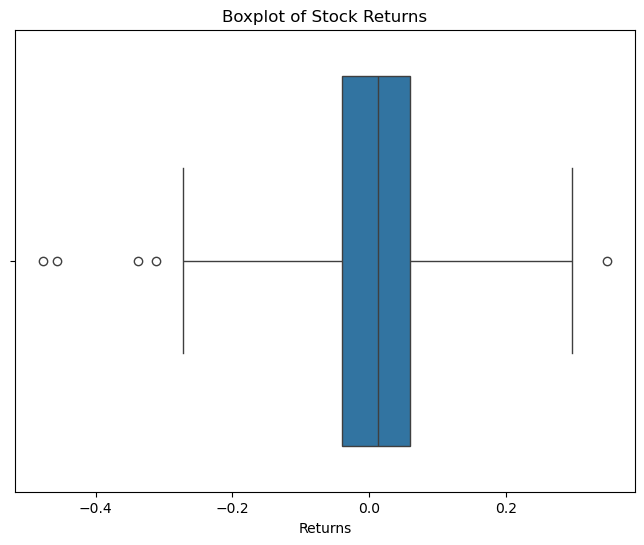

Median relative to mean of daily log returns: -0.0036271420641342464


In [240]:
# Test 2: Boxplot and median

excess_median = rt_monthly.mean() - rt_monthly.median() # REMPLACER PAR VALEUR DU TABLEAU

plt.figure(figsize=(8, 6))
sns.boxplot(x=rt_monthly,whis=2.5)
plt.title('Boxplot of Stock Returns')
plt.xlabel('Returns')
plt.show()

print(f'Median relative to mean of daily log returns: {excess_median}')

In [241]:
# Test 3: Jarque-Bera test

# Jarque-Bera test to check for skewness and kurtosis
jarque_bera_results = stats.jarque_bera(rt_monthly)
JB = pd.Series({
    "JB": round(jarque_bera_results[0], 4),
    "p-value": jarque_bera_results[1]
})

print(f"H0: Skew = 0 and Kurt = 3 (normality of skewness and tails)\nH1: Skew ≠ 0 and/or Kurt ≠ 3 (non-normality of skewness and tails)\n-----\n{JB}\n-----")

if JB["p-value"] > 0.05:
    print("Fail to reject the null hypothesis, the returns skewness and tails are not significantly different from those of a normal distribution.")
else : 
    print("Reject the null hypothesis, the returns skewness and/or tails are significantly different from those of a normal distribution.")

H0: Skew = 0 and Kurt = 3 (normality of skewness and tails)
H1: Skew ≠ 0 and/or Kurt ≠ 3 (non-normality of skewness and tails)
-----
JB         2.514987e+02
p-value    2.442026e-55
dtype: float64
-----
Reject the null hypothesis, the returns skewness and/or tails are significantly different from those of a normal distribution.


In [242]:
# TEST 4: D'Agostino normal skewness test (1970)

# D'Agostino test with H1 being excplicitly negative skewness
agostino_result = stats.skewtest(rt_monthly, alternative='less')
AGST = pd.Series({
    "AGST": agostino_result[0],
    "p-value": agostino_result[1]
})

print(f"H0: Skew = 0 (normality of skewness)\nH1: Skew < 0 (negative skewness, non-normality)\n-----\n{AGST}\n-----")

if AGST["p-value"] > 0.05:
    print("Fail to reject the null hypothesis, the returns skewness is not significantly different from a normal distribution.")
else : 
    print("Reject the null hypothesis, the returns skewness is negative and is significantly different from a normal distribution.")

H0: Skew = 0 (normality of skewness)
H1: Skew < 0 (negative skewness, non-normality)
-----
AGST      -5.004387e+00
p-value    2.802003e-07
dtype: float64
-----
Reject the null hypothesis, the returns skewness is negative and is significantly different from a normal distribution.


#### Stylized Fact 4: Returns have heavy tails

In [243]:
# TEST 1: Kurtosis of log returns (4th centralized standardized moment)

kurt_daily = kurtosis(rt_daily, nan_policy='omit')
kurt_weekly = kurtosis(rt_weekly, nan_policy='omit')
kurt_monthly = kurtosis(rt_monthly, nan_policy='omit')
kurt_yearly = kurtosis(rt_yearly, nan_policy='omit')

def describe_kurt(kurtosis):
    return (
        "Heavy tails (leptokurtic)" if kurtosis > 3 else
        "Light tails (platokurtic)" if kurtosis < 3 else
        "Normal distribution tails (mesokurtic)"
    )

print("Kurtosis of log returns\n-----")
print(f"Daily: {kurt_daily} → {describe_kurt(kurt_daily)}")
print(f"Weekly: {kurt_weekly} → {describe_kurt(kurt_weekly)}")
print(f"Monthly: {kurt_monthly} → {describe_kurt(kurt_monthly)}")
print(f"Annual: {kurt_yearly} → {describe_kurt(kurt_yearly)}")


"""Results indicates the impact of 'Theorem on Aggregation of iid returns' (p.157 lecture), see LLN/CLT.
 'Les log-returns sont leptokurtiques à haute fréquence (daily/weekly), mais l’agrégation temporelle réduit la lourdeur des queues.' """

Kurtosis of log returns
-----
Daily: 12.317582944041591 → Heavy tails (leptokurtic)
Weekly: 3.1820309200048325 → Heavy tails (leptokurtic)
Monthly: 2.6715025517381585 → Light tails (platokurtic)
Annual: 1.8746684511155962 → Light tails (platokurtic)


"Results indicates the impact of 'Theorem on Aggregation of iid returns' (p.157 lecture), see LLN/CLT.\n 'Les log-returns sont leptokurtiques à haute fréquence (daily/weekly), mais l’agrégation temporelle réduit la lourdeur des queues.' "

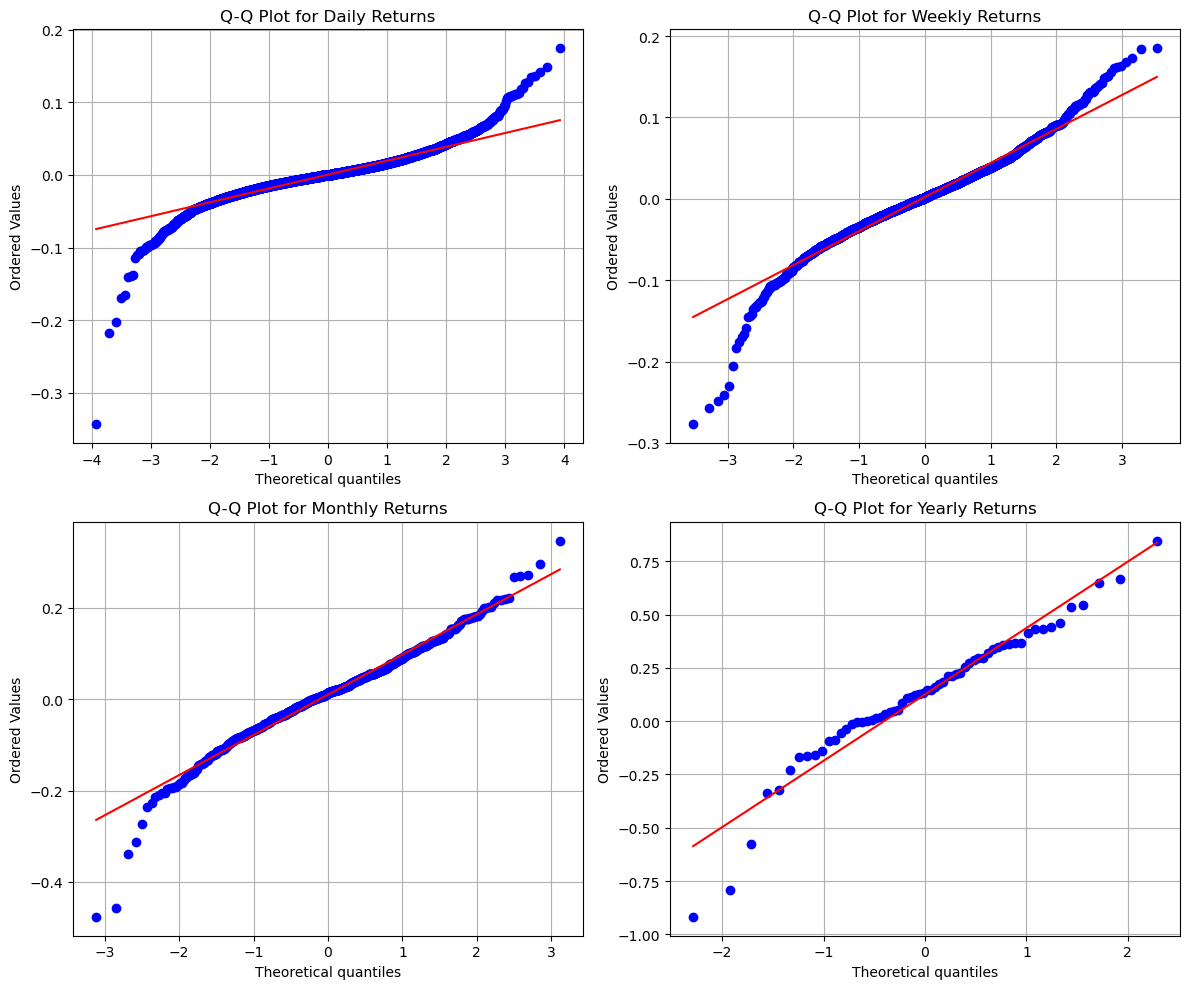

In [244]:
# TEST 2: Q-Q Plot of Log Returns

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

stats.probplot(rt_daily, dist="norm", plot=axs[0, 0])
axs[0, 0].set_title("Q-Q Plot for Daily Returns")
axs[0, 0].grid(True)

stats.probplot(rt_weekly, dist="norm", plot=axs[0, 1])
axs[0, 1].set_title("Q-Q Plot for Weekly Returns")
axs[0, 1].grid(True)

stats.probplot(rt_monthly, dist="norm", plot=axs[1, 0])
axs[1, 0].set_title("Q-Q Plot for Monthly Returns")
axs[1, 0].grid(True)

stats.probplot(rt_yearly, dist="norm", plot=axs[1, 1])
axs[1, 1].set_title("Q-Q Plot for Yearly Returns")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [245]:
# TEST 3: Hill Estimator (Pareto) of 5% daily and weekly returns (not relevant on weekly and monthly)

# Tail quantile
tail_quantile = 0.95

# Daily absolute log returns
pos_rt_daily = rt_daily[rt_daily > 0]
neg_rt_daily = np.abs(rt_daily[rt_daily < 0])
right_tail_daily = pwl.Fit(pos_rt_daily, xmin=np.quantile(pos_rt_daily, tail_quantile))
left_tail_daily = pwl.Fit(neg_rt_daily, xmin=np.quantile(neg_rt_daily, tail_quantile))

# Weekly absolute log returns
pos_rt_weekly = rt_weekly[rt_weekly > 0]
neg_rt_weekly = np.abs(rt_weekly[rt_weekly < 0])
right_tail_weekly = pwl.Fit(pos_rt_weekly, xmin=np.quantile(pos_rt_weekly, tail_quantile))
left_tail_weekly = pwl.Fit(neg_rt_weekly, xmin=np.quantile(neg_rt_weekly, tail_quantile))

HILL = pd.DataFrame({
    "Daily": [left_tail_daily.alpha, right_tail_daily.alpha],
    "Weekly": [left_tail_weekly.alpha, right_tail_weekly.alpha],
}, index= ["Left.Alpha", "Right.Alpha"])


print(f"Hill test for daily and weekly log returns:\n-----\n{HILL}\n-----")
print(f"The left tail of daily log returns is {"heavier" if left_tail_daily.alpha > right_tail_daily.alpha else "lighter"} than the right tail")
print(f"The left tail of weekly log returns is {"heavier" if left_tail_weekly.alpha > right_tail_weekly.alpha else "lighter"} than the right tail")

Hill test for daily and weekly log returns:
-----
                Daily    Weekly
Left.Alpha   4.078365  4.186764
Right.Alpha  4.512420  5.288657
-----
The left tail of daily log returns is lighter than the right tail
The left tail of weekly log returns is lighter than the right tail


In [246]:
"""
Note on the interpretation of Hill vs Kurtosis:
The Hill estimator is specifically designed to quantify the “heaviness” of the tail of a distribution. 
Unlike kurtosis, which looks at all data points, the Hill focuses only on the largest observations (or smallest for the left tail), i.e., the extreme events.

Kurtosis is very sensitive to outliers (4th order), Hill describes the general shape of tails.
Hill quantifies the tail thickness, i.e., the general likelihood of observing extreme events.
It does not spike for a single extreme outlier, unlike kurtosis which can be strongly influenced by a single extreme.
Kurtosis is more descriptive, good for stylized facts, but does not differentiate moderate vs. extreme tails as precisely as Hill.

In our case:
The results show that tails differ from normal distribution tails, but moderately, and mainly due to extreme outliers.
A normal distribution has alpha = approx 7.
"""

'\nNote on the interpretation of Hill vs Kurtosis:\nThe Hill estimator is specifically designed to quantify the “heaviness” of the tail of a distribution. \nUnlike kurtosis, which looks at all data points, the Hill focuses only on the largest observations (or smallest for the left tail), i.e., the extreme events.\n\nKurtosis is very sensitive to outliers (4th order), Hill describes the general shape of tails.\nHill quantifies the tail thickness, i.e., the general likelihood of observing extreme events.\nIt does not spike for a single extreme outlier, unlike kurtosis which can be strongly influenced by a single extreme.\nKurtosis is more descriptive, good for stylized facts, but does not differentiate moderate vs. extreme tails as precisely as Hill.\n\nIn our case:\nThe results show that tails differ from normal distribution tails, but moderately, and mainly due to extreme outliers.\nA normal distribution has alpha = approx 7.\n'

#### Stylized facts 5: Aggregational Gaussianity

In [247]:
"""
The non gaussianity of high frequency TS is already proven by the skewness and kurtosis test which reject the hypothesis.
These two test gives hint about the gaussianity of low freq TS (see kurtosis, or skew).
QQ plot also gives hint about this.
"""

'\nThe non gaussianity of high frequency TS is already proven by the skewness and kurtosis test which reject the hypothesis.\nThese two test gives hint about the gaussianity of low freq TS (see kurtosis, or skew).\nQQ plot also gives hint about this.\n'

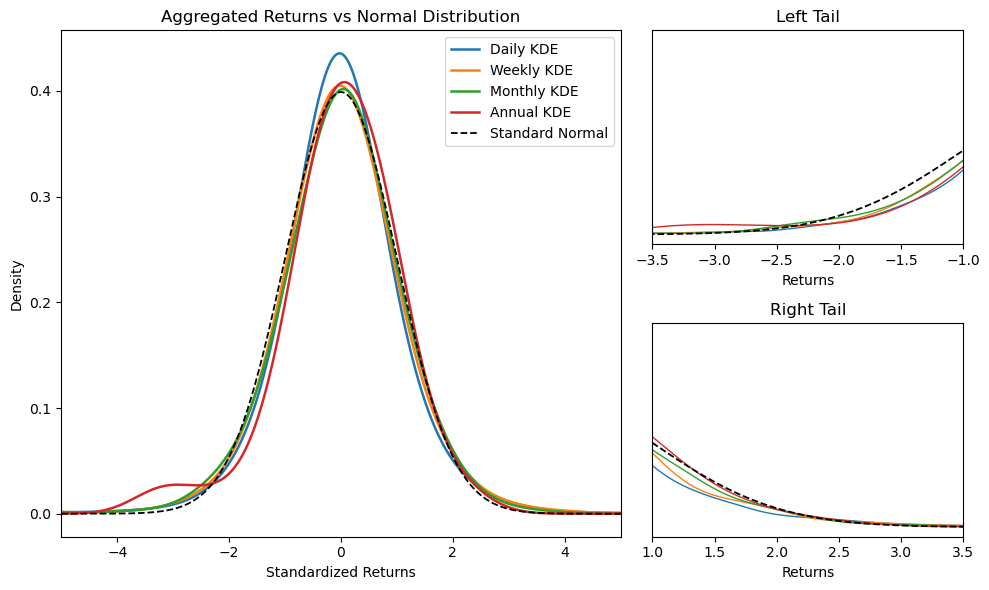

In [248]:
# TEST 1: Trouver le bon plot:

# Idée : les 3 KDE standardized vs standard normal, avec zoom partie gauche et droite pour voir la différence entre chaque
# Faire une standardisation de chaque pour obtenir le bon cdf a la même échelle

# Create a dictionnary of standardized time series
rt_std = {
    "Daily": (rt_daily - np.mean(rt_daily)) / np.std(rt_daily),
    "Weekly": (rt_weekly - np.mean(rt_weekly)) / np.std(rt_weekly),
    "Monthly": (rt_monthly - np.mean(rt_monthly)) / np.std(rt_monthly),
    "Annual": (rt_yearly - np.mean(rt_yearly)) / np.std(rt_yearly)
}

# Support of X
x = np.linspace(-5, 5, 1000)
normal_pdf = norm.pdf(x)

# Plot configuration
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[1.8, 1], height_ratios=[1, 1])
axs = [
    fig.add_subplot(gs[:, 0]),   # grand plot à gauche
    fig.add_subplot(gs[0, 1]),   # zoom sur left tail
    fig.add_subplot(gs[1, 1])    # zoom sur right tail
]

# Define colors for visual clarity
colors = {
    "Daily": "#E74C3C",   # rouge vif
    "Weekly": "#E67E22",  # orange
    "Monthly": "#F1C40F", # jaune doré
    "Annual": "#2ECC71"   # vert clair
}

# Global view of kernel vs normal
for label, data in rt_std.items():
    kde = gaussian_kde(data, bw_method=0.5)
    axs[0].plot(x, kde(x), label=f'{label} KDE', lw=1.8)
axs[0].plot(x, normal_pdf, color='black', linestyle='--', lw=1.3, label='Standard Normal')
axs[0].set_title('Aggregated Returns vs Normal Distribution')
axs[0].legend()
axs[0].set_xlim(-5, 5)
axs[0].set_xlabel('Standardized Returns')
axs[0].set_ylabel('Density')

# Zoom plot to better capture the spread
zoom_ranges = [(-3.5, -1), (1, 3.5)]
zoom_titles = ['Left Tail', 'Right Tail']

for ax, (xlim, title) in zip(axs[1:], zip(zoom_ranges, zoom_titles)):
    for label, data in rt_std.items():
        kde = gaussian_kde(data)
        ax.plot(x, kde(x), lw=1)
    ax.plot(x, normal_pdf, color='black', linestyle='--', lw=1.3)
    ax.set_xlim(*xlim)
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xlabel('Returns')


plt.tight_layout()
plt.show()

In [249]:
"""
the Shapiro-Wilk test is highly sensitive to tail behavior, the
Anderson-Darling places more weight on the tails, and the Lilliefors test adapts Kolmogorov-Smirnov
specifically for normality.
We choose daily, weekly, and monthly, since annually as not enough values
"""

'\nthe Shapiro-Wilk test is highly sensitive to tail behavior, the\nAnderson-Darling places more weight on the tails, and the Lilliefors test adapts Kolmogorov-Smirnov\nspecifically for normality.\nWe choose daily, weekly, and monthly, since annually as not enough values\n'

In [250]:
# TEST 2: Lilliefors test on log returns

# Perform Lilliefors test for all frequencies
lilli_results = {freq: lilliefors(data) for freq, data in rt.items()}

# Create a DataFrame from the results
LILF = pd.DataFrame({
        "Statistic": [round(result[0], 6) for result in lilli_results.values()],
        "p-value": [round(result[1], 6) for result in lilli_results.values()]
    }, index= lilli_results.keys()).transpose()

def describe_lilli(x):
    return (
        f"Fail to reject the null hypothesis, the time series doesn't differ significantly from a normal distribution"
        if x > 0.05 else
        f"Reject the null hypothesis, the time series log returns differ significantly from a normal distribution"
    )

# Print results for each frequency
print(f"H0: The time series follow a normal distribution\nH1: The time series doesn't follow a normal distribution\n-----\n{LILF}\n-----")

for freq, (_, p_value) in lilli_results.items():
    print(f"• {freq}: {describe_lilli(p_value)}")

H0: The time series follow a normal distribution
H1: The time series doesn't follow a normal distribution
-----
              Daily    Weekly   Monthly    Annual
Statistic  0.063813  0.041345  0.044903  0.101594
p-value    0.001000  0.001000  0.001465  0.150950
-----
• Daily: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution
• Weekly: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution
• Monthly: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution
• Annual: Fail to reject the null hypothesis, the time series doesn't differ significantly from a normal distribution


In [251]:
# TEST 3: Shapiro-Wilk test on log returns

shapiro_results = {freq: shapiro(data) for freq, data in rt.items()}

# Create a DataFrame from the results
SW = pd.DataFrame({
        "Statistic": [round(result[0], 6) for result in shapiro_results.values()],
        "p-value": [round(result[1], 6) for result in shapiro_results.values()]
    }, index= lilli_results.keys()).transpose()


def describe_shapiro(x):
    return (
        f"Fail to reject the null hypothesis, the time series doesn't differ significantly from a normal distribution"
        if x > 0.05 else
        f"Reject the null hypothesis, the time series log returns differ significantly from a normal distribution"
    )

# Print results for each frequency
print(f"H0: The time series follow a normal distribution\nH1: The time series doesn't follow a normal distribution\n-----\n{SW}\n-----")

for freq, (_, p_value) in shapiro_results.items():
    print(f"• {freq}: {describe_shapiro(p_value)}")

H0: The time series follow a normal distribution
H1: The time series doesn't follow a normal distribution
-----
              Daily    Weekly   Monthly    Annual
Statistic  0.929003  0.970101  0.973727  0.949792
p-value    0.000000  0.000000  0.000000  0.013040
-----
• Daily: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution
• Weekly: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution
• Monthly: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution
• Annual: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution


/opt/anaconda3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15856.
  res = hypotest_fun_out(*samples, **kwds)


In [252]:
"""
Shapiro is extremly sensitive to tail behavior, explaning why the p-value is so low.
With N being high (observations), even small gap have a huge impact
"""

'\nShapiro is extremly sensitive to tail behavior, explaning why the p-value is so low.\nWith N being high (observations), even small gap have a huge impact\n'

In [253]:
# Test 4: Anderson-Darling test on log returns

anderson_results = {freq: anderson(data, dist='norm') for freq, data in rt.items()}

# Create a DataFrame from the results
AD = pd.DataFrame({
        "Statistic": [result.statistic for result in anderson_results.values()],
        "Sig.15%": [result.critical_values[0] for result in anderson_results.values()],
        "Sig.10%": [result.critical_values[1] for result in anderson_results.values()],
        "Sig.5%": [result.critical_values[2] for result in anderson_results.values()],
        "Sig.1%": [result.critical_values[4] for result in anderson_results.values()]
    }, index= lilli_results.keys()).transpose()

def describe_anderson(x, critical_five_p):
    return (
        f"Fail to reject the null hypothesis, the time series doesn't differ significantly from a normal distribution"
        if x < critical_five_p else
        f"Reject the null hypothesis, the time series log returns differ significantly from a normal distribution"
    )

# Print results for each frequency
print(f"H0: The time series follow a normal distribution\nH1: The time series doesn't follow a normal distribution\n-----\n{AD}\n-----")

for freq, (stat, crit_value, _) in anderson_results.items():
    print(f"• {freq}: {describe_anderson(stat, crit_value[2])}")

H0: The time series follow a normal distribution
H1: The time series doesn't follow a normal distribution
-----
                Daily     Weekly   Monthly    Annual
Statistic  168.635146  14.688942  2.956607  0.761191
Sig.15%      0.576000   0.575000  0.573000  0.544000
Sig.10%      0.656000   0.655000  0.653000  0.620000
Sig.5%       0.787000   0.786000  0.783000  0.744000
Sig.1%       1.092000   1.091000  1.086000  1.032000
-----
• Daily: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution
• Weekly: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution
• Monthly: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution
• Annual: Reject the null hypothesis, the time series log returns differ significantly from a normal distribution


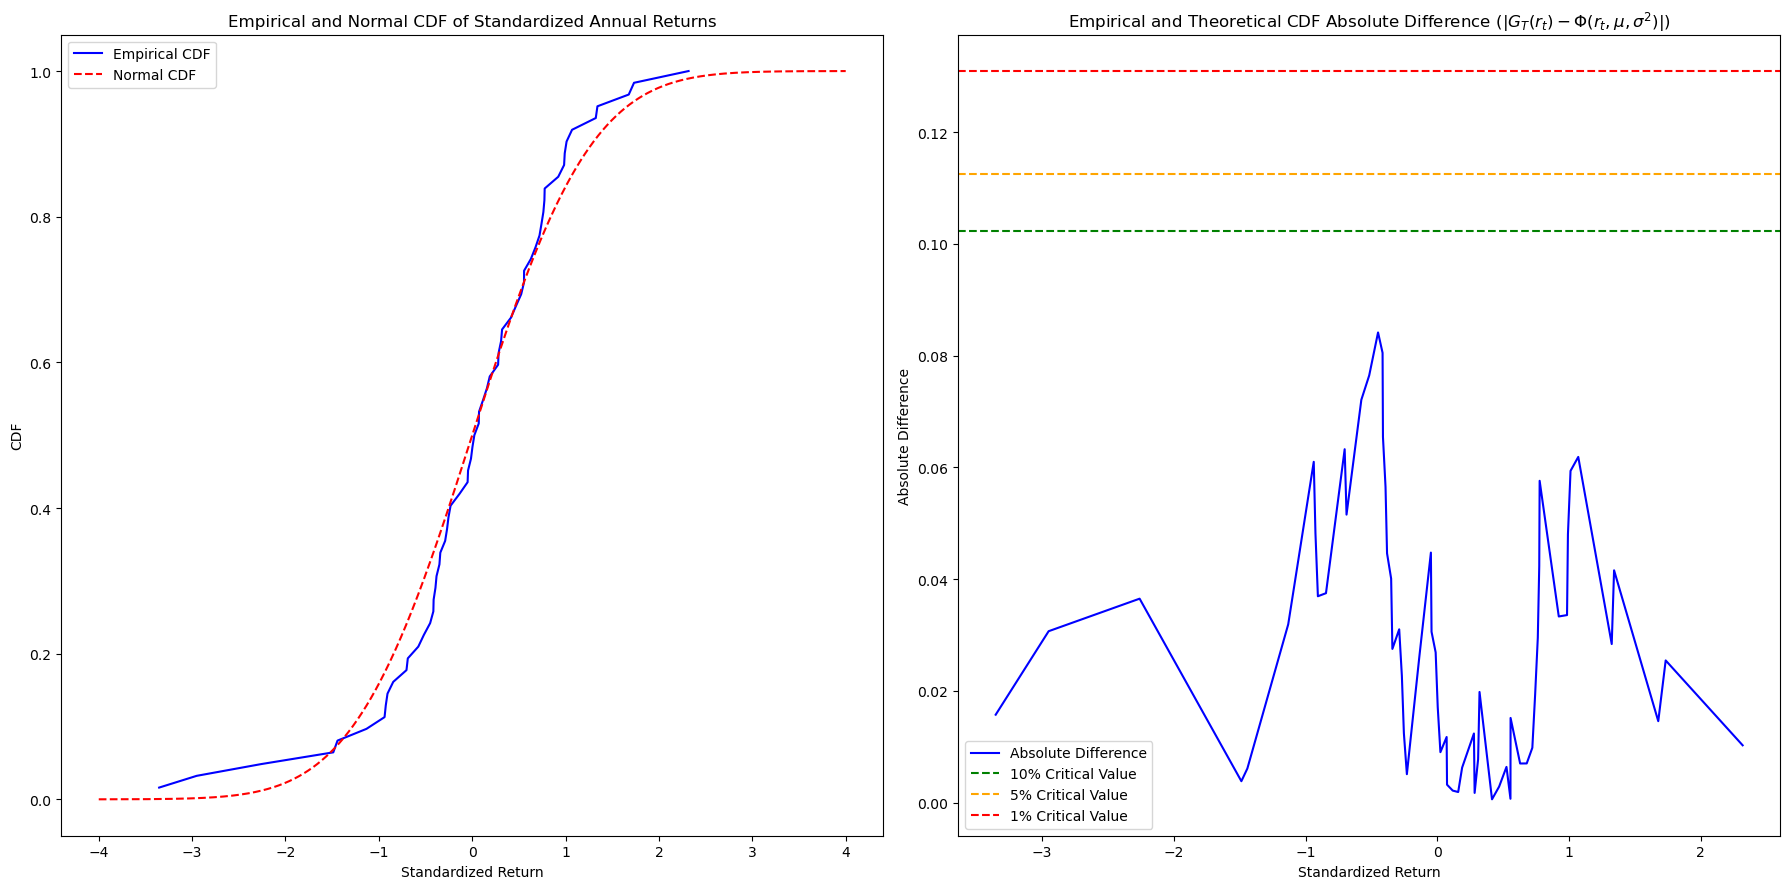

In [254]:
# TEST 5: Empirical CDF and Lillifore graph

# Define the empirical yearly CDF of log returns
rt_yearly_std = rt_std["Annual"]
cdf_values = np.sort(rt_yearly_std)
cdf_empirical = np.arange(1, len(rt_yearly_std)+1) / len(rt_yearly_std)
obs_yearly = len(rt_yearly_std)

# Define the theoritical CDF values 
cdf_normal_values = np.linspace(-4, 4, 1000)
cdf_theoretical_full = stats.norm.cdf(cdf_normal_values)

# Calculate the absolute difference
cdf_theoretical = stats.norm.cdf(cdf_values)
abs_diff = np.abs(cdf_empirical - cdf_theoretical)

# Compute lilifores critical values (from original values)
critical_values = { "10%": 0.805 / np.sqrt(obs_yearly), "5%": 0.886 / np.sqrt(obs_yearly), "1%": 1.031 / np.sqrt(obs_yearly) }

# Plotting histogram and normal distribution
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

# Plot the theoretical vs empirical normal CDF
axs[0].plot(cdf_values, cdf_empirical, label='Empirical CDF', color='blue')
axs[0].plot(cdf_normal_values, cdf_theoretical_full, label='Normal CDF', color='red', linestyle='--')
axs[0].set_title('Empirical and Normal CDF of Standardized Annual Returns')
axs[0].set_xlabel('Standardized Return')
axs[0].set_ylabel('CDF')
axs[0].legend()

# Plot the difference
axs[1].plot(cdf_values, abs_diff, label='Absolute Difference',color='blue')
axs[1].set_title('Empirical and Theoretical CDF Absolute Difference ($|G_T(r_t) - \Phi(r_t, \mu, \sigma^2)|$)')
axs[1].set_xlabel('Standardized Return')
axs[1].set_ylabel('Absolute Difference')

# Plot Lilliefors critical values ()
axs[1].axhline(y=critical_values["10%"], label='10% Critical Value', linestyle='--', color='green')
axs[1].axhline(y=critical_values["5%"], label='5% Critical Value', linestyle='--', color='orange')
axs[1].axhline(y=critical_values["1%"], label='1% Critical Value', linestyle='--', color='red')
axs[1].legend()

plt.tight_layout()
plt.show()

#### Stylized Fact 6: Returns are not autocorrelated

In [255]:
"""
Note that no correlation doesn't mean independance, but independance mean correlation
"""

"\nNote that no correlation doesn't mean independance, but independance mean correlation\n"

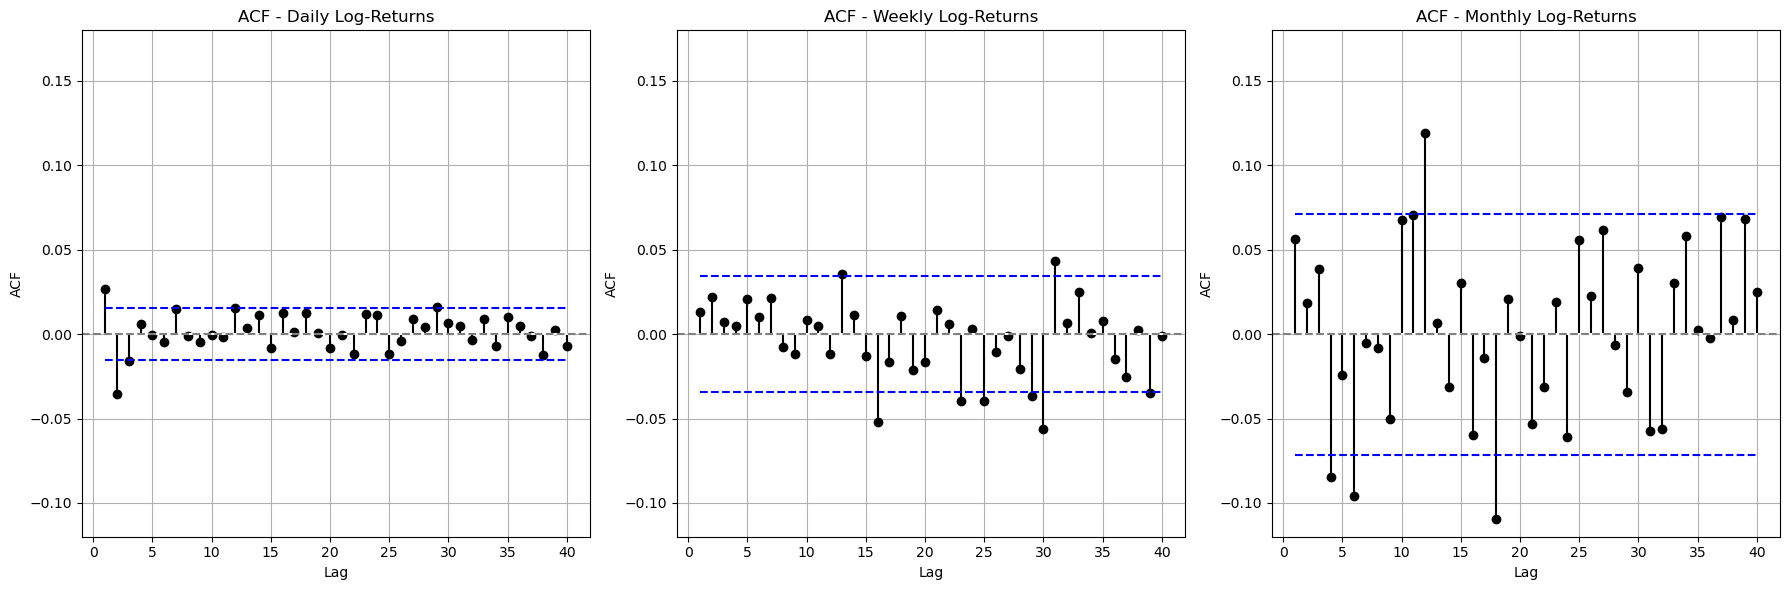

Autocorrelation function
-----
               Daily    Weekly   Monthly
Interval    0.015565  0.034192  0.071332
Violations  4.000000  8.000000  4.000000
-----
• Significant autocorrelation of daily returns at lags: 1, 2, 3, 29
• Significant autocorrelation of weekly returns at lags: 13, 16, 23, 25, 29, 30, 31, 39
• Significant autocorrelation of monthly returns at lags: 4, 6, 12, 18


In [256]:
# TEST 1: ACF plotting

# Define function setting
lags = 40
valueint = 1.96

# Define the DataFrame structure
agg_acf = {}

# Create a subplot to plot ACF
fig, axs = plt.subplots(1, len(rt) - 1, figsize=(18, 6))  # len(rt) - 1 pour exclure "Annual"

# Plot and create data structure
for i, (freq, data) in enumerate(rt.items()):
    if freq == "Annual":
        continue  

    # Compute ACF values
    acf_values = acf(data, nlags=lags)
    confint = valueint / np.sqrt(len(data))
    confint_upper = np.full(lags, confint)
    confint_lower = -np.full(lags, confint)

    # Detect interval violation
    acf_lags = acf_values[1:]
    violations = np.where((acf_lags > confint) | (acf_lags < -confint))[0] + 1
    n_viol = len(violations)
    violidx = ", ".join(map(str, violations)) if n_viol > 0 else None
    agg_acf[freq] = [confint, n_viol, violidx]


    # Plot the result
    axs[i].stem(np.arange(1, lags + 1), acf_values[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
    axs[i].axhline(y=0, color='gray', linestyle='--')
    axs[i].plot(np.arange(1, lags + 1), confint_upper, color='blue', linestyle='dashed')
    axs[i].plot(np.arange(1, lags + 1), confint_lower, color='blue', linestyle='dashed')
    axs[i].set_ylim(-0.12, 0.18)
    axs[i].set_title(f'ACF - {freq} Log-Returns')
    axs[i].set_xlabel('Lag')
    axs[i].set_ylabel('ACF')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# Create a summary data frame
ACFT = pd.DataFrame({key: value[:-1] for key, value in agg_acf.items() if value},index=['Interval', "Violations"])

# Print table and results for each frequency
print(f"Autocorrelation function\n-----\n{ACFT}\n-----")
for freq, (_, _, idx) in agg_acf.items():
    print(f"• Significant autocorrelation of {freq.lower()} returns at lags: {idx}")

In [257]:
# TEST 2 : Ljung-Box and Box-Pierce tests for autocorrelation

# Define the lag to test for
lag_lj = 25
valueint = 1.96
LBBP = {}

# Compute LB and BP tests on daily, weekly, and monthly returns
for freq, series in rt.items():
    if freq == "Annual":
        continue
    
    # Compute the Ljung-Box and Box-Pierce test
    lbbp_results = acorr_ljungbox(series, lags=np.arange(1, lag_lj+1), boxpierce=True)

    # Compute ACF test and critical value for daily returns
    acf_val = acf(series, nlags=lag_lj)
    act_confint = np.full(lag_lj, valueint) / np.sqrt(len(series))
    acf_tstat_0 = (acf_val[1:] - 0) / np.sqrt(1 / len(series))
    crit_value_5_BP = stats.chi2.ppf(0.95, np.arange(1, lag_lj+1))

    # Create a dataframe for each time series
    ar_summary = pd.DataFrame({
        "ACF": acf_val[1:],
        "ACF diam.": act_confint,
        "ACF t-test": acf_tstat_0,
        "LB stat": lbbp_results["lb_stat"],
        "LB pval": lbbp_results["lb_pvalue"],
        "BP stat": lbbp_results["bp_stat"],
        "BP pval": lbbp_results["bp_pvalue"],
        "Critical": crit_value_5_BP,
    }, index=np.arange(1, lag_lj+1))
    ar_summary.index.name = "Lags"

    LBBP[freq] = ar_summary


def describe_LB(x):
    return (
        f"Fail to reject the null hypothesis, no autocorrelation detected"
        if x > 0.05 else
        f"Reject the null hypothesis, autocorrelation detected"
    )

# Print Results
print(f"H0: No autocorrelation up to lag p\nH1: One autocorrelation or more up to lag p\n-----")

for freq, value in LBBP.items():
    print(f"{freq} log returns:")  
    print(f"• Lag 1 - Stat: {round(value.loc[1, "LB stat"], 5)} | p-value: {round(value.loc[1, "LB pval"], 5)} → {describe_LB(value.loc[1, "LB pval"])}")
    print(f"• Lag 5 - Stat: {round(value.loc[5, "LB stat"], 5)} | p-value: {round(value.loc[5, "LB pval"], 5)} → {describe_LB(value.loc[5, "LB pval"])}")
    print(f"• Lag 10 - Stat: {round(value.loc[10, "LB stat"], 5)} | p-value: {round(value.loc[10, "LB pval"], 5)} → {describe_LB(value.loc[10, "LB pval"])}\n-----")

print(f"ACF, Ljung-Box and Box-Pierc table:\n-----\n{LBBP["Daily"]}\n-----")

H0: No autocorrelation up to lag p
H1: One autocorrelation or more up to lag p
-----
Daily log returns:
• Lag 1 - Stat: 11.39881 | p-value: 0.00073 → Reject the null hypothesis, autocorrelation detected
• Lag 5 - Stat: 35.71274 | p-value: 0.0 → Reject the null hypothesis, autocorrelation detected
• Lag 10 - Stat: 39.98744 | p-value: 2e-05 → Reject the null hypothesis, autocorrelation detected
-----
Weekly log returns:
• Lag 1 - Stat: 0.54222 | p-value: 0.46152 → Fail to reject the null hypothesis, no autocorrelation detected
• Lag 5 - Stat: 3.83588 | p-value: 0.57328 → Fail to reject the null hypothesis, no autocorrelation detected
• Lag 10 - Stat: 6.5572 | p-value: 0.76648 → Fail to reject the null hypothesis, no autocorrelation detected
-----
Monthly log returns:
• Lag 1 - Stat: 2.42147 | p-value: 0.11968 → Fail to reject the null hypothesis, no autocorrelation detected
• Lag 5 - Stat: 9.7225 | p-value: 0.08349 → Fail to reject the null hypothesis, no autocorrelation detected
• Lag 1

In [258]:
"""
The ACF coefficients of daily returns are very small (below 3 % for all lags) and alternate in sign, indicating weak short-term noise rather than systematic serial dependence.
The corresponding t-statistics exceed the 1.96 threshold for a few early lags, leading the Ljung–Box test to reject the null of no autocorrelation.
However, given the tiny magnitude of the autocorrelations, this dependence is statistically significant but economically irrelevant — consistent with the stylized fact that raw returns are nearly uncorrelated.
"""

'\nThe ACF coefficients of daily returns are very small (below 3 % for all lags) and alternate in sign, indicating weak short-term noise rather than systematic serial dependence.\nThe corresponding t-statistics exceed the 1.96 threshold for a few early lags, leading the Ljung–Box test to reject the null of no autocorrelation.\nHowever, given the tiny magnitude of the autocorrelations, this dependence is statistically significant but economically irrelevant — consistent with the stylized fact that raw returns are nearly uncorrelated.\n'

#### Stylized Fact 7:  Volatility clustering and long range dependance of squared returns

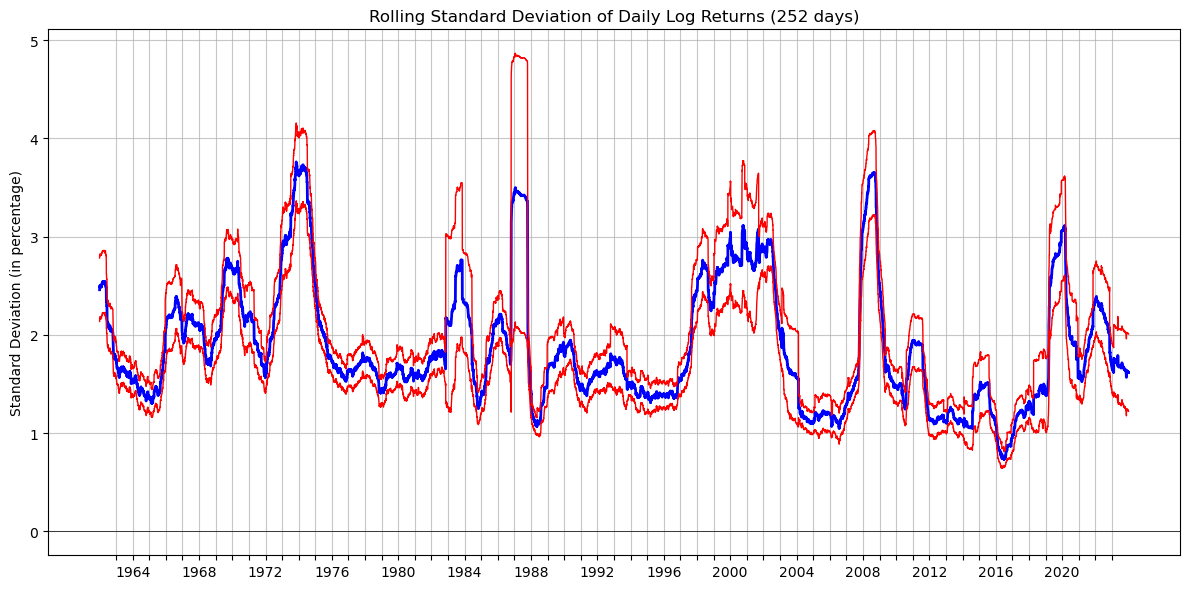

In [259]:
# TEST 1: 252 days rolling volatility plot

# Define rolling parameter
window = 252

# Compute rolling standard deviation and standard error
roll_std_252 = rt_daily.rolling(window=window).std(ddof=0)
roll_mu4 = rt_daily.rolling(window=window).apply(lambda x: np.mean(x**4), raw=True)
stderr = (1 / (2 * roll_std_252)) * np.sqrt(np.maximum(roll_mu4 - roll_std_252**4, 0)) / np.sqrt(window)

# Confidence interval upper and lower
roll_std_upper = roll_std_252 + 1.96 * stderr
roll_std_lower = roll_std_252 - 1.96 * stderr

# Define dataframe for rolling data
data2plot = pd.DataFrame({
    'Std': roll_std_252,
    'Lower.Bound': roll_std_upper,
    'Upper.Bound': roll_std_lower
}).dropna()


# Plot the rolling std
plt.figure(figsize=(12, 6))
plt.plot(data2plot.index, data2plot["Std"] * 100, color='blue', linestyle='-', linewidth=2)

# Plot confidence interval
plt.plot(data2plot.index, data2plot["Lower.Bound"] * 100, color='red', linestyle='-', linewidth=1)
plt.plot(data2plot.index, data2plot["Upper.Bound"] * 100, color='red', linestyle='-', linewidth=1)

# Format the graph
date_labels = pd.date_range(start=data2plot.index.min(), end=data2plot.index.max(), freq='YE-DEC')
formatted_labels = [f'{date.year}' if date.year % 4 == 0 else '' for date in date_labels]
plt.xticks(date_labels, formatted_labels, rotation=0)

# Mise en forme du graphique
plt.xlabel('')
plt.ylabel('Standard Deviation (in percentage)')
plt.title(f'Rolling Standard Deviation of Daily Log Returns ({window} days)')
plt.grid(True, linestyle='-', alpha=0.7)
plt.axhline(0, linestyle='-', color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

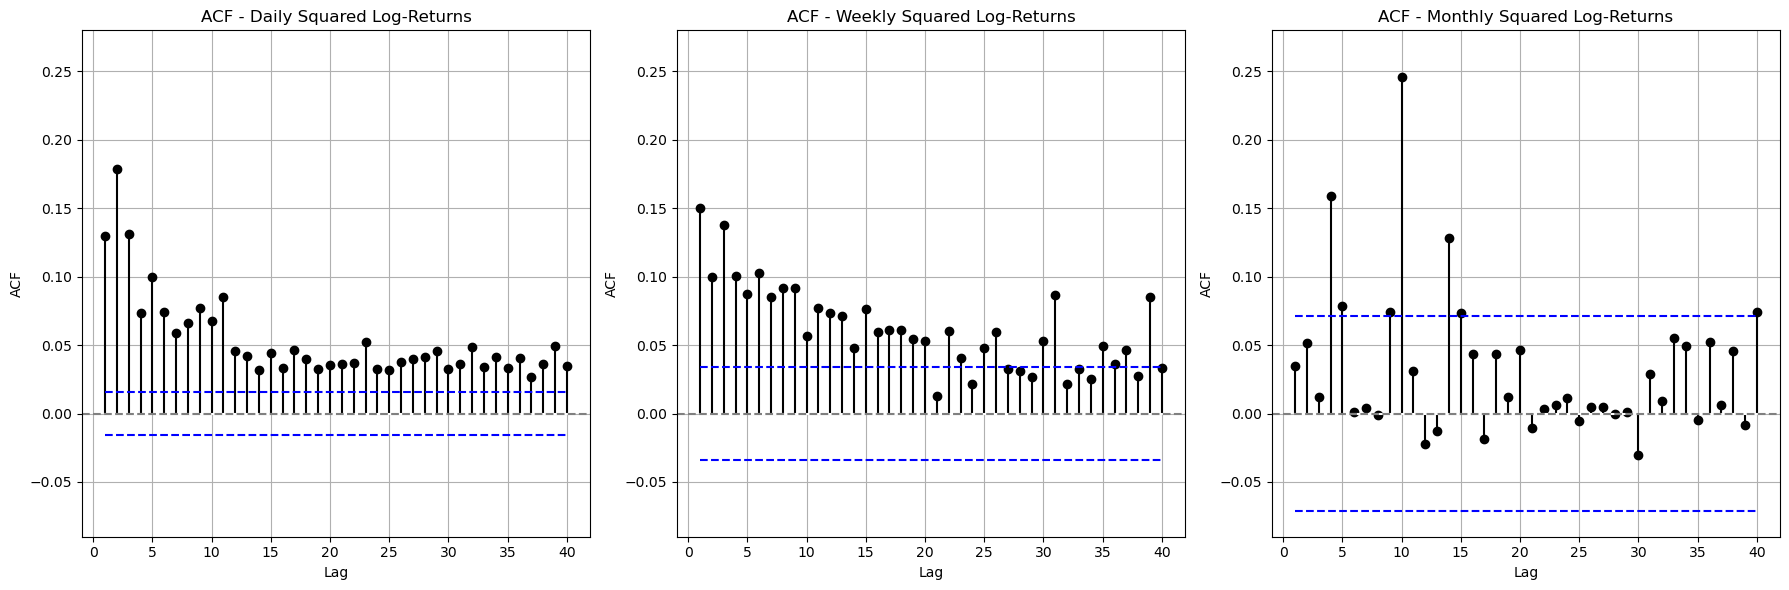

Autocorrelation function
-----
                Daily     Weekly   Monthly
Interval     0.015565   0.034192  0.071332
Violations  40.000000  30.000000  7.000000
-----
• Significant autocorrelation of daily squared returns at lags: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40
• Significant autocorrelation of weekly squared returns at lags: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 26, 30, 31, 35, 36, 37, 39
• Significant autocorrelation of monthly squared returns at lags: 4, 5, 9, 10, 14, 15, 40


In [260]:
# TEST 2: ACF plotting of squared log returns

# Define dictionnary of squared log returns
rt_sqrd = {freq: np.power(value, 2) for freq, value in rt.items()}

# Define function setting
lags_sqrd = 40
valueint = 1.96

# Define the DataFrame structure
agg_acf_sqrd = {}

# Create a subplot to plot ACF
fig, axs = plt.subplots(1, len(rt_sqrd) - 1, figsize=(18, 6))  # len(rt) - 1 pour exclure "Annual"

# Plot and create data structure
for i, (freq, data) in enumerate(rt_sqrd.items()):
    if freq == "Annual":
        continue  

    # Compute ACF values
    acf_values = acf(data, nlags=lags_sqrd)
    confint = valueint / np.sqrt(len(data))
    confint_upper = np.full(lags_sqrd, confint)
    confint_lower = -np.full(lags_sqrd, confint)

    # Detect interval violation
    acf_lags_sqrd = acf_values[1:]
    violations = np.where((acf_lags_sqrd > confint) | (acf_lags_sqrd < -confint))[0] + 1
    n_viol = len(violations)
    violidx = ", ".join(map(str, violations)) if n_viol > 0 else None
    agg_acf_sqrd[freq] = [confint, n_viol, violidx]


    # Plot the result
    axs[i].stem(np.arange(1, lags_sqrd + 1), acf_values[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
    axs[i].axhline(y=0, color='gray', linestyle='--')
    axs[i].plot(np.arange(1, lags_sqrd + 1), confint_upper, color='blue', linestyle='dashed')
    axs[i].plot(np.arange(1, lags_sqrd + 1), confint_lower, color='blue', linestyle='dashed')
    axs[i].set_ylim(-0.09, 0.28)
    axs[i].set_title(f'ACF - {freq} Squared Log-Returns')
    axs[i].set_xlabel('Lag')
    axs[i].set_ylabel('ACF')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# Create a summary data frame
ACFT_SQ = pd.DataFrame({key: value[:-1] for key, value in agg_acf_sqrd.items() if value},index=['Interval', "Violations"])

# Print table and results for each frequency
print(f"Autocorrelation function\n-----\n{ACFT_SQ}\n-----")
for freq, (_, _, idx) in agg_acf_sqrd.items():
    print(f"• Significant autocorrelation of {freq.lower()} squared returns at lags: {idx}")

In [261]:
# TEST 3: Ljung-Box and Box-Pierce tests for autocorrelation of squared log returns

# Define the lag to test for
lag_lj_sqrd = 25
valueint = 1.96
LBBP_SQ = {}

# Compute LB and BP tests on daily, weekly, and monthly returns
for freq, series in rt_sqrd.items():
    if freq == "Annual":
        continue
    
    # Compute the Ljung-Box and Box-Pierce test
    lbbp_results = acorr_ljungbox(series, lags=np.arange(1, lag_lj_sqrd+1), boxpierce=True)

    # Compute ACF test and critical value for daily returns
    acf_val = acf(series, nlags=lag_lj_sqrd)
    act_confint = np.full(lag_lj_sqrd, valueint) / np.sqrt(len(series))
    acf_tstat_0 = (acf_val[1:] - 0) / np.sqrt(1 / len(series))
    crit_value_5_BP = stats.chi2.ppf(0.95, np.arange(1, lag_lj_sqrd+1))

    # Create a dataframe for each time series
    ar_summary = pd.DataFrame({
        "ACF": acf_val[1:],
        "ACF diam.": act_confint,
        "ACF t-test": acf_tstat_0,
        "LB stat": lbbp_results["lb_stat"],
        "LB pval": lbbp_results["lb_pvalue"],
        "BP stat": lbbp_results["bp_stat"],
        "BP pval": lbbp_results["bp_pvalue"],
        "Critical": crit_value_5_BP,
    }, index=np.arange(1, lag_lj_sqrd+1))
    ar_summary.index.name = "Lags"

    LBBP_SQ[freq] = ar_summary

# Print results
def describe_LB(x):
    return (
        f"Fail to reject the null hypothesis, no autocorrelation detected"
        if x > 0.05 else
        f"Reject the null hypothesis, autocorrelation detected"
    )

print(f"H0: No autocorrelation up to lag p\nH1: One autocorrelation or more up to lag p\n-----")

for freq, value in LBBP_SQ.items():
    print(f"{freq} log returns:")  
    print(f"• Lag 1 - Stat: {round(value.loc[1, "LB stat"], 5)} | p-value: {round(value.loc[1, "LB pval"], 5)} → {describe_LB(value.loc[1, "LB pval"])}")
    print(f"• Lag 5 - Stat: {round(value.loc[5, "LB stat"], 5)} | p-value: {round(value.loc[5, "LB pval"], 5)} → {describe_LB(value.loc[5, "LB pval"])}")
    print(f"• Lag 10 - Stat: {round(value.loc[10, "LB stat"], 5)} | p-value: {round(value.loc[10, "LB pval"], 5)} → {describe_LB(value.loc[10, "LB pval"])}\n-----")

print(f"ACF, Ljung-Box and Box-Pierc table:\n-----\n{LBBP_SQ["Daily"]}\n-----")

H0: No autocorrelation up to lag p
H1: One autocorrelation or more up to lag p
-----
Daily log returns:
• Lag 1 - Stat: 266.04638 | p-value: 0.0 → Reject the null hypothesis, autocorrelation detected
• Lag 5 - Stat: 1288.26636 | p-value: 0.0 → Reject the null hypothesis, autocorrelation detected
• Lag 10 - Stat: 1666.69166 | p-value: 0.0 → Reject the null hypothesis, autocorrelation detected
-----
Weekly log returns:
• Lag 1 - Stat: 73.8806 | p-value: 0.0 → Reject the null hypothesis, autocorrelation detected
• Lag 5 - Stat: 227.73346 | p-value: 0.0 → Reject the null hypothesis, autocorrelation detected
• Lag 10 - Stat: 352.19087 | p-value: 0.0 → Reject the null hypothesis, autocorrelation detected
-----
Monthly log returns:
• Lag 1 - Stat: 0.90773 | p-value: 0.34072 → Fail to reject the null hypothesis, no autocorrelation detected
• Lag 5 - Stat: 26.89001 | p-value: 6e-05 → Reject the null hypothesis, autocorrelation detected
• Lag 10 - Stat: 77.56846 | p-value: 0.0 → Reject the null 

In [262]:
# TEST 4: GARCH model to test volatility clustering on daily log returns

# Compute rt_daily in percent to ease estimation convergence
rt_daily_pct = rt_daily * 100

# Compute the result of GARCH(1,1) model (captures most of the persisting volatility)
garch_spec = arch_model(rt_daily_pct, vol='Garch', p=1, q=1, dist='t', mean='Zero', rescale=False)
garch_fit = garch_spec.fit(disp=False)

# Extract GARCH results (omega / 100^2 to adjust for the scaling factor)
GARCH = pd.DataFrame({
    'Estimate': [garch_fit.params["omega"] / np.power(100,2), garch_fit.params["alpha[1]"], garch_fit.params["beta[1]"]], 
    'p-value': [garch_fit.pvalues["omega"], garch_fit.pvalues["alpha[1]"], garch_fit.pvalues["beta[1]"]], 
}, index=["omega", "alpha[1]", "beta[1]"])


# Printing GARCH results
def describe_garch(res):
    print("Estimates significance:")
     # Omega
    if res.loc["omega", "p-value"] < 0.05:
        print(f"• Omega (constant factor): is significant, confirming that a stable unconditional variance is present in the time series.")
    else:
        print(f"• Omega (constant factor): is not significant, indicating that most of the variance dynamics are explained by shock and memory effects")
    # Alpha
    if res.loc["alpha[1]", "p-value"] < 0.05:
        print(f"• Alpha (ARCH factor): is significant, indicating the effect of the previous period shock (squared returns) on today's volatility.")
    else:
        print(f"• Alpha (ARCH factor): is not significant, indicating the that the previous period shock (squared returns) do not have a significant impact on today's volatility.")
    # Beta
    if res.loc["beta[1]", "p-value"] < 0.05:
        print(f"• Beta (GARCH factor): is significant, indicating that volatility exhibits strong persistence and that shocks take time to decay.")
    else:
        print(f"• Beta (GARCH factor): is not significant, indicating that volatility doesn't exhibit strong persistence and that shocks decay fast.")
    
    print("-----\nGARCH interpretation:")

    # Volatility clustering intensity
    persistence = res.loc["alpha[1]", "Estimate"] + res.loc["beta[1]", "Estimate"]
    if persistence < 0.5:
        print(f"• Volatility is weakly persistent (alpha + beta = {persistence:.2f}), indicating low volatlity clustering.")
    elif persistence < 0.95:
        print(f"• Volatility is moderately persistent (alpha + beta = {persistence:.2f}), indicating moderate volatlity clustering.")
    else:
        print(f"• Volatility is highly persistent (alpha + beta = {persistence:.2f}), indicating strong volatlity clustering.")

    # Volatility clustering decomposition
    if res.loc["alpha[1]", "Estimate"] > res.loc["beta[1]", "Estimate"]:
        print("• Volatility clustering is mainly driven by recent shocks (alpha > beta), indicating the effect of the previous period shock.")
    else:
        print("• Volatility clustering is mainly driven by persistence of past shocks (beta > alpha), indicating the effect of volatility long-term memory.")



print(f"\n----- GARCH(1,1) Model Results -----\n\n{GARCH}\n-----")
describe_garch(GARCH)


----- GARCH(1,1) Model Results -----

          Estimate       p-value
omega     0.000003  5.437650e-04
alpha[1]  0.058261  8.339929e-10
beta[1]   0.934258  0.000000e+00
-----
Estimates significance:
• Omega (constant factor): is significant, confirming that a stable unconditional variance is present in the time series.
• Alpha (ARCH factor): is significant, indicating the effect of the previous period shock (squared returns) on today's volatility.
• Beta (GARCH factor): is significant, indicating that volatility exhibits strong persistence and that shocks take time to decay.
-----
GARCH interpretation:
• Volatility is highly persistent (alpha + beta = 0.99), indicating strong volatlity clustering.
• Volatility clustering is mainly driven by persistence of past shocks (beta > alpha), indicating the effect of volatility long-term memory.


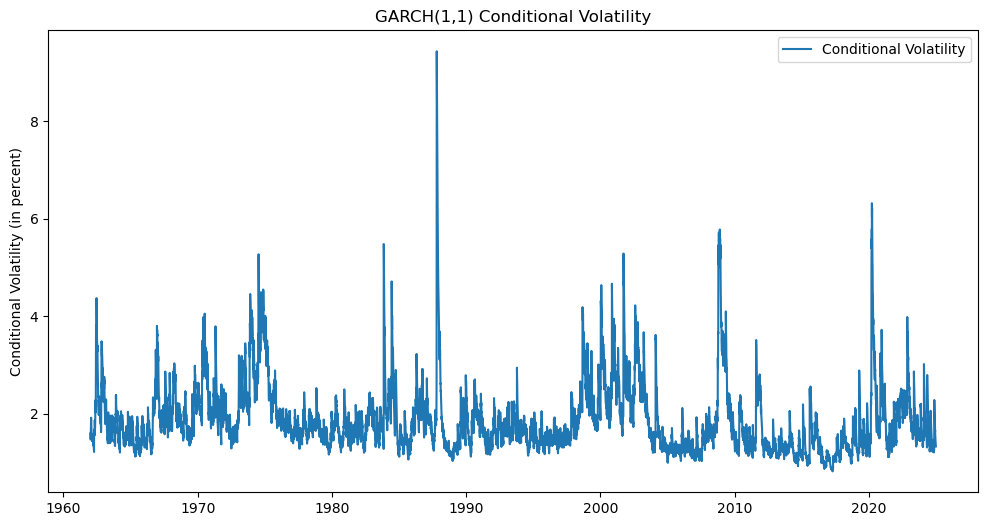

In [263]:
# TEST 5: Plot GARCH(1,1) conditional volatility

# Define implied condition volatility (in percent)
cond_volatility = garch_fit.conditional_volatility

# Plot conditional volatility
plt.figure(figsize=(12, 6))
plt.plot(garch_fit.conditional_volatility, label='Conditional Volatility')
plt.title('GARCH(1,1) Conditional Volatility')
plt.ylabel('Conditional Volatility (in percent)')
plt.legend()
plt.show()


#### Stylized Facts 8: Leverage effect

In [264]:
"""
Leverage effect says: loss in stock price -> increase in vol
"""

'\nLeverage effect says: loss in stock price -> increase in vol\n'

In [265]:
# Preliminary: retreive and transform VIX data

# Retreive VIX history on Yahoo Finance
VIX = yf.download("^VIX", start="1961-01-02", end="2024-12-31", auto_adjust=False)

# Convert the VIX DataFrame and extract closing price
VIX.set_index(pd.to_datetime(VIX.index))
VIX = VIX.sort_index()
VIX_daily = VIX["Adj Close"]["^VIX"]
VIX_daily.name = "VIX.d"

# Merge simple prices and VIX
Pt_daily_VIX = pd.merge(Pt_daily, VIX_daily, on='Date',how='outer').dropna()

Pt_daily_VIX

[*********************100%***********************]  1 of 1 completed


,Pt.d,VIX.d
Date,,
1990-01-02,6.854023,17.240000
1990-01-03,6.868858,18.190001
1990-01-04,6.861440,19.219999
1990-01-05,6.883694,20.110001
1990-01-08,6.942799,20.260000
...,...,...
2024-12-23,110.926964,16.780001
2024-12-24,112.082031,14.270000
2024-12-26,112.072083,14.730000


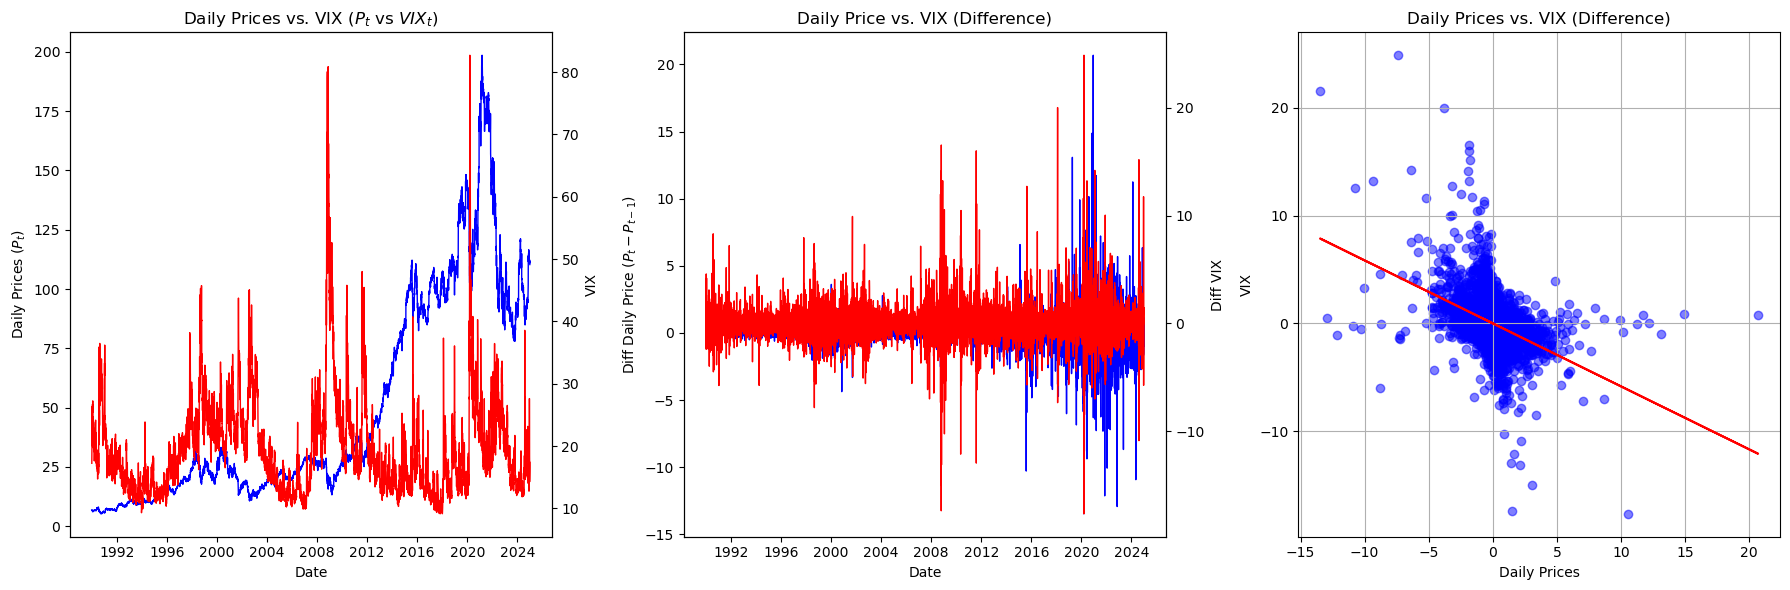

Linear Regression
-----
Intercept    0.006874
Slope       -0.584038
r-squared    0.163882
p-value      0.000000
dtype: float64
-----
The beta coefficient (-0.58) is  significantly different from 0, indicating a negative relation between prices and volatility
The R2 is equal to 0.1639, indicating that 16.39% of VIX variance is explained by the daily prices variance (according to the linear model)


In [266]:
# TEST 1: Plot price-volatility relation and linear regression

# Compute the absolute difference of prices and VIX
Pt_daily_VIX_change = Pt_daily_VIX.diff().dropna()

# Compute the linear regression
linreg = linregress(Pt_daily_VIX_change["Pt.d"], Pt_daily_VIX_change["VIX.d"])
slope = linreg.slope
intercept = linreg.intercept
regline = np.polyval([slope, intercept], Pt_daily_VIX_change['Pt.d'])

# Create a serie for the linear regression result
LR = pd.Series({
    "Intercept": intercept,
    "Slope": slope,
    "r-squared": np.power(linreg.rvalue, 2),
    "p-value": linreg.pvalue
})

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot price vs VIX
axs[0].plot(Pt_daily_VIX.index, Pt_daily_VIX['Pt.d'], label='Daily Prices', color='blue', lw=1)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Daily Prices ($P_t$)', color='black')
axs[0].set_title('Daily Prices vs. VIX ($P_t$ vs $VIX_t$)')
# Right axe
axs0_alt = axs[0].twinx()
axs0_alt.plot(Pt_daily_VIX.index, Pt_daily_VIX['VIX.d'], label='VIX',color='red', lw=1)
axs0_alt.set_ylabel('VIX', color='black')

# Plot price change vs VIX change
axs[1].plot(Pt_daily_VIX_change.index, Pt_daily_VIX_change['Pt.d'], label='Diff Daily Price', color='blue', lw=1)
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Diff Daily Price ($P_t - P_{t-1}$)', color='black')
axs[1].set_title('Daily Price vs. VIX (Difference)')
# Right axe
axs1_alt = axs[1].twinx()
axs1_alt.plot(Pt_daily_VIX_change.index, Pt_daily_VIX_change['VIX.d'], label='Diff VIX', color='red', lw=1)
axs1_alt.set_ylabel('Diff VIX', color='black')

# Plot scatter and regression line
axs[2].scatter(Pt_daily_VIX_change['Pt.d'], Pt_daily_VIX_change['VIX.d'], color='blue', marker='o', alpha=0.5)
axs[2].plot(Pt_daily_VIX_change['Pt.d'], regline, color='red', linewidth=1.5)
axs[2].set_xlabel('Daily Prices')
axs[2].set_ylabel('VIX')
axs[2].set_title('Daily Prices vs. VIX (Difference)')
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Print linear regression result
def describe_linreg(beta, pval, rsq):
    print(f"The beta coefficient ({round(beta, 2)}) is {'' if pval < 0.05 else 'not'} significantly different from 0, indicating a {'negative' if beta < 0 else 'positive'} relation between prices and volatility")
    print(f"The R2 is equal to {round(rsq, 4)}, indicating that {round(rsq * 100, 2)}% of VIX variance is explained by the daily prices variance (according to the linear model)")

print(f"Linear Regression\n-----\n{LR}\n-----")
describe_linreg(LR["Slope"], LR["p-value"], LR["r-squared"])

In [267]:
"""Note that R2 is not a perfect indicator and tends to be inflated, mention it in the PDF. For more details, see CH2 - slide 66 (theory)"""

'Note that R2 is not a perfect indicator and tends to be inflated, mention it in the PDF. For more details, see CH2 - slide 66 (theory)'

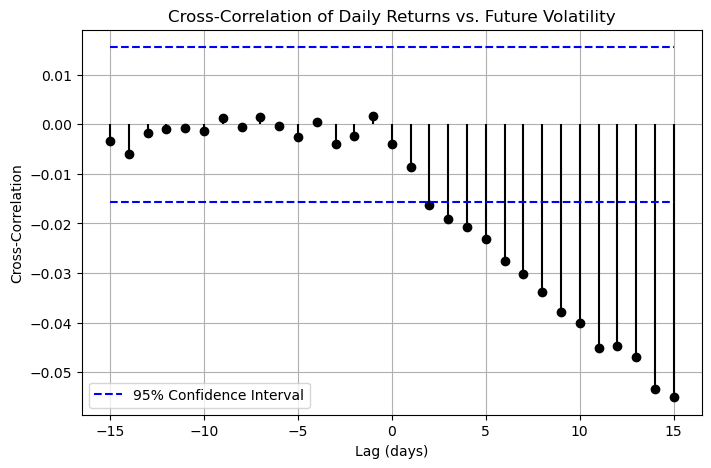

The cross-correlation shows evidence of leverage effect, negative returns tend to precede increased volatility.


In [268]:
# TEST 2: Cross correlation of log returns and future volatility

# Compute rolling volatility
window = 15
lag_cc = 15
roll_std_15 = rt_daily.rolling(window=window).std(ddof=0).dropna()

# Adjust daily log returns to account for the substract of the rolling window
rt_daily_adj15 = rt_daily[-len(roll_std_15):]

# Define the cross-correlation function
def ccf(x, y, lag_max=20):
    result = ss.correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)
    return result[lo:hi]

# Compute the CC between daily log returns and future volatility
cross_corr = ccf(rt_daily_adj15, roll_std_15, lag_max=lag_cc)

# Define variables for plotting
lag_values = np.arange(-lag_cc, lag_cc + 1)
confin = 1.96 / np.sqrt(len(rt_daily_adj15))
confint_upper = np.full(len(lag_values), confin)
confint_lower = np.full(len(lag_values), -confin)

# Plot the cross-correlation
plt.figure(figsize=(8, 5))
plt.stem(lag_values, cross_corr, basefmt=" ", linefmt='black')
plt.plot(lag_values, confint_upper, color='blue', linestyle='dashed', label="95% Confidence Interval")
plt.plot(lag_values, confint_lower, color='blue', linestyle='dashed')
plt.xlabel('Lag (days)')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation of Daily Returns vs. Future Volatility')
plt.legend()
plt.grid(True)
plt.show()

if np.any(cross_corr < -confin):
    print("The cross-correlation shows evidence of leverage effect, negative returns tend to precede increased volatility.")
else:
    print("The cross-correlation doesn't show evidence of leverage effect, negative returns do not significantly precede increased volatility.")


In [269]:
# TEST 3: Granger causality test

# Create a series with only negative returns (adjusted for 15 period)
neg_rt_daily_adj15 = rt_daily_adj15.apply(lambda x: x if x < 0 else 0)

# Create a dataframe of daily log returns (adjusted) vs. 15 days rolling vol
neg_rt_daily_vol15 = pd.merge(roll_std_15, neg_rt_daily_adj15, on='Date',how='outer').dropna()
neg_rt_daily_vol15.columns = ['neg.rt.d.15', 'vol.d.15']

# Compute Granger result
lag_gc = 15
granger_result = grangercausalitytests(neg_rt_daily_vol15[["vol.d.15", "neg.rt.d.15"]], maxlag=lag_gc, verbose=False)

# Create Dataframe to summarize results
GC = pd.DataFrame(
    [{
            "F-Stat": granger_result[lag][0]['ssr_ftest'][0],
            "p-value": granger_result[lag][0]['ssr_ftest'][1],
            "Causality": granger_result[lag][0]['ssr_ftest'][1] < 0.05}
        for lag in range(1, lag_gc + 1)
    ], index= range(1, lag_gc + 1))
GC.index.name = "Lags"

# Print results
def describe_granger(res):
    siglags = res.index[res['Causality']].tolist()
    if not siglags:
        return "Fail to reject the null hypothesis, no evidence that negative returns cause volatility at any lag"
    else:
        return f"Reject the null hypothesis, negative returns cause volatility on {len(siglags)} lags. The effect occurs from {min(siglags)} to {max(siglags)} days (or more) after the observation"

print(f"H0: Past negative values of X do not contain any predictive information about Y\nH1: Past negative values of X contain useful information that helps predict Y\n-----\n{GC}\n-----")
print(describe_granger(GC))


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


H0: Past negative values of X do not contain any predictive information about Y
H1: Past negative values of X contain useful information that helps predict Y
-----
          F-Stat        p-value  Causality
Lags                                      
1     463.101933  2.852799e-101       True
2     210.706282   4.874046e-91       True
3     121.034165   1.667669e-77       True
4      79.661162   4.907039e-67       True
5      57.463095   1.883964e-59       True
6      40.892236   1.003231e-49       True
7      30.857293   9.351219e-43       True
8      25.091468   8.118458e-39       True
9      20.513146   9.014561e-35       True
10     16.769174   1.244078e-30       True
11     13.198871   1.915131e-25       True
12     10.524874   4.217264e-21       True
13     10.058030   1.854863e-21       True
14      9.466913   2.694388e-21       True
15      8.986993   3.066201e-21       True
-----
Reject the null hypothesis, negative returns cause volatility on 15 lags. The effect occurs from 1 

### Part II - Pricing Models

In [270]:
import pandas_datareader.data as pdr

##### Load data and transformation

In [271]:
# Import SP500 data from yahoo finance
SP500 = yf.download("^GSPC", start="1951-12-31", end="2024-12-31", auto_adjust=False)

# Import fama french factors from Prof. Ken French library
FF = pdr.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1951-12-31', end="2024-12-31")[0]

SP500

[*********************100%***********************]  1 of 1 completed
/var/folders/z6/j_nqb41d7p71wfmbz0m97p200000gn/T/ipykernel_5398/2052466818.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF = pdr.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1951-12-31', end="2024-12-31")[0]
/var/folders/z6/j_nqb41d7p71wfmbz0m97p200000gn/T/ipykernel_5398/2052466818.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF = pdr.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1951-12-31', end="2024-12-31")[0]


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
1951-12-31,23.770000,23.770000,23.770000,23.770000,23.770000,1440000
1952-01-02,23.799999,23.799999,23.799999,23.799999,23.799999,1070000
1952-01-03,23.879999,23.879999,23.879999,23.879999,23.879999,1220000
1952-01-04,23.920000,23.920000,23.920000,23.920000,23.920000,1480000
1952-01-07,23.910000,23.910000,23.910000,23.910000,23.910000,1540000
...,...,...,...,...,...,...
2024-12-23,5974.069824,5974.069824,5978.250000,5902.569824,5940.250000,3593280000
2024-12-24,6040.040039,6040.040039,6040.100098,5981.439941,5984.629883,1757720000


In [272]:
# Rename dictionary stock return (Part I) for clarity and distinction
stock_rt = rt

In [273]:
# Compute SP500 daily adjusted closing prices
sp500_Pt_daily_all = SP500["Adj Close"].squeeze()
sp500_Pt_daily_all.index = pd.to_datetime(sp500_Pt_daily_all.index)
# Rename series
sp500_Pt_daily_all.name = "SP500.Pt.d.all"

# Compute closing log prices
sp500_pt_daily_all = np.log(sp500_Pt_daily_all)
sp500_pt_monthly_all = sp500_pt_daily_all.resample('ME').last()
sp500_pt_monthly_all.index = pd.to_datetime(sp500_pt_monthly_all.index)
# Rename series
sp500_pt_daily_all.name, sp500_pt_monthly_all.name = 'SP500.pt.d.all', 'SP500.pt.m.all'

# Compute log return of SP500
sp500_rt_daily_all = sp500_pt_daily_all.diff().dropna()
sp500_rt_monthly_all = sp500_pt_monthly_all.diff().dropna()
# Rename series
sp500_rt_daily_all.name, sp500_rt_monthly_all.name = 'SP500.rt.d.all', 'SP500.rt.m.all'

sp500_rt_daily_all.head()

Date
1952-01-02    0.001261
1952-01-03    0.003356
1952-01-04    0.001674
1952-01-07   -0.000418
1952-01-08   -0.003771
Name: SP500.rt.d.all, dtype: float64

In [274]:
# Extract risk-free rate and transform index
Rf_monthly_all = FF["RF"].squeeze()
Rf_monthly_all.index = Rf_monthly_all.index.to_timestamp(how='end') + pd.offsets.MonthEnd(0)
Rf_monthly_all.index = Rf_monthly_all.index.normalize()
# Rename series
Rf_monthly_all.name = "Rf.m.all"

# Extract the fama french factors
Ff_monthly_all = FF.iloc[:,:3]
Ff_monthly_all.index = Ff_monthly_all.index.to_timestamp(how='end') + pd.offsets.MonthEnd(0)
Ff_monthly_all.index = Ff_monthly_all.index.normalize()
# Rename dataframe
Ff_monthly_all.name = 'Ff.m.all'

Ff_monthly_all.head()

,Mkt-RF,SMB,HML
Date,,,
1951-12-31,3.33,-2.24,-1.55
1952-01-31,1.45,-0.65,1.48
1952-02-29,-2.64,0.85,-0.62
1952-03-31,4.44,-2.97,2.23
1952-04-30,-4.97,0.49,-0.03


In [275]:
# Extract monthly stock return and convert to frame
stock_rt_monthly_all = stock_rt["Monthly"].to_frame()

# Create aggregated monthly log return table (SP500, ticker)
agg_rt_monthly_all = stock_rt_monthly_all.merge(sp500_rt_monthly_all, on='Date', how='inner')
agg_rt_monthly_all = agg_rt_monthly_all.rename(columns={'rt.m.all': TICKER, "SP500.rt.m.all": "SP500"})
agg_rt_monthly_all.index = pd.to_datetime(agg_rt_monthly_all.index)

# Multiply by factor of 100 to later match FF factors
agg_rt_monthly_all_pct = agg_rt_monthly_all * 100

agg_rt_monthly_all.head()

,DIS,SP500
Date,,
1962-02-28,-0.003341,0.016139
1962-03-31,0.002580,-0.005878
1962-04-30,-0.083666,-0.063973
1962-05-31,-0.071597,-0.089914
1962-06-30,-0.175983,-0.085381


In [276]:
# Merge aggregated return table with fama french factors
rt_fct_monthly_all = agg_rt_monthly_all_pct.join(Ff_monthly_all, how='inner').join(Rf_monthly_all, how='inner')
rt_fct_monthly_all = rt_fct_monthly_all.rename(columns={"Rf.m.all": "RF"})
rt_fct_monthly_all.index = rt_fct_monthly_all.index.to_period("M")

# Transform excess market return to CRSP VW
rt_fct_monthly_all["Mkt-RF"] = rt_fct_monthly_all["Mkt-RF"] + rt_fct_monthly_all["RF"];
rt_fct_monthly_all = rt_fct_monthly_all.rename(columns={"Mkt-RF": "CRSP VW", "^GSPC":"sp500"})
rt_fct_monthly_all.name = "return.factor.monthly"

rt_fct_monthly_all.head()

,DIS,SP500,CRSP VW,SMB,HML,RF
Date,,,,,,
1962-02,-0.334075,1.613872,2.01,-1.15,0.82,0.20
1962-03,0.257958,-0.587767,-0.48,0.66,-1.58,0.20
1962-04,-8.366624,-6.397322,-6.37,-0.85,0.14,0.22
1962-05,-7.159747,-8.991392,-8.42,-3.14,2.73,0.24
1962-06,-17.598349,-8.538145,-8.30,-0.46,2.42,0.20


In [277]:
# Compute excess monthly return factor table
# Applied on ticker, sp500 and CRSP returns
zt_fct_monthly_all = rt_fct_monthly_all.copy()
zt_fct_monthly_all.iloc[:,:3] = zt_fct_monthly_all.iloc[:,:3].subtract(zt_fct_monthly_all.iloc[:,-1], axis=0)

zt_fct_monthly_all.head()

,DIS,SP500,CRSP VW,SMB,HML,RF
Date,,,,,,
1962-02,-0.534075,1.413872,1.81,-1.15,0.82,0.20
1962-03,0.057958,-0.787767,-0.68,0.66,-1.58,0.20
1962-04,-8.586624,-6.617322,-6.59,-0.85,0.14,0.22
1962-05,-7.399747,-9.231392,-8.66,-3.14,2.73,0.24
1962-06,-17.798349,-8.738145,-8.50,-0.46,2.42,0.20


In [278]:
# Date range
ts_start_date = pd.to_datetime('1961-01-02')
ts_end_date = pd.to_datetime('2024-12-31')

# Filter based on the date range
rt_fct_m = rt_fct_monthly_all.loc[ts_start_date:ts_end_date]
zt_fct_m = zt_fct_monthly_all.loc[ts_start_date:ts_end_date]

zt_fct_m.head()

,DIS,SP500,CRSP VW,SMB,HML,RF
Date,,,,,,
1962-02,-0.534075,1.413872,1.81,-1.15,0.82,0.20
1962-03,0.057958,-0.787767,-0.68,0.66,-1.58,0.20
1962-04,-8.586624,-6.617322,-6.59,-0.85,0.14,0.22
1962-05,-7.399747,-9.231392,-8.66,-3.14,2.73,0.24
1962-06,-17.798349,-8.738145,-8.50,-0.46,2.42,0.20


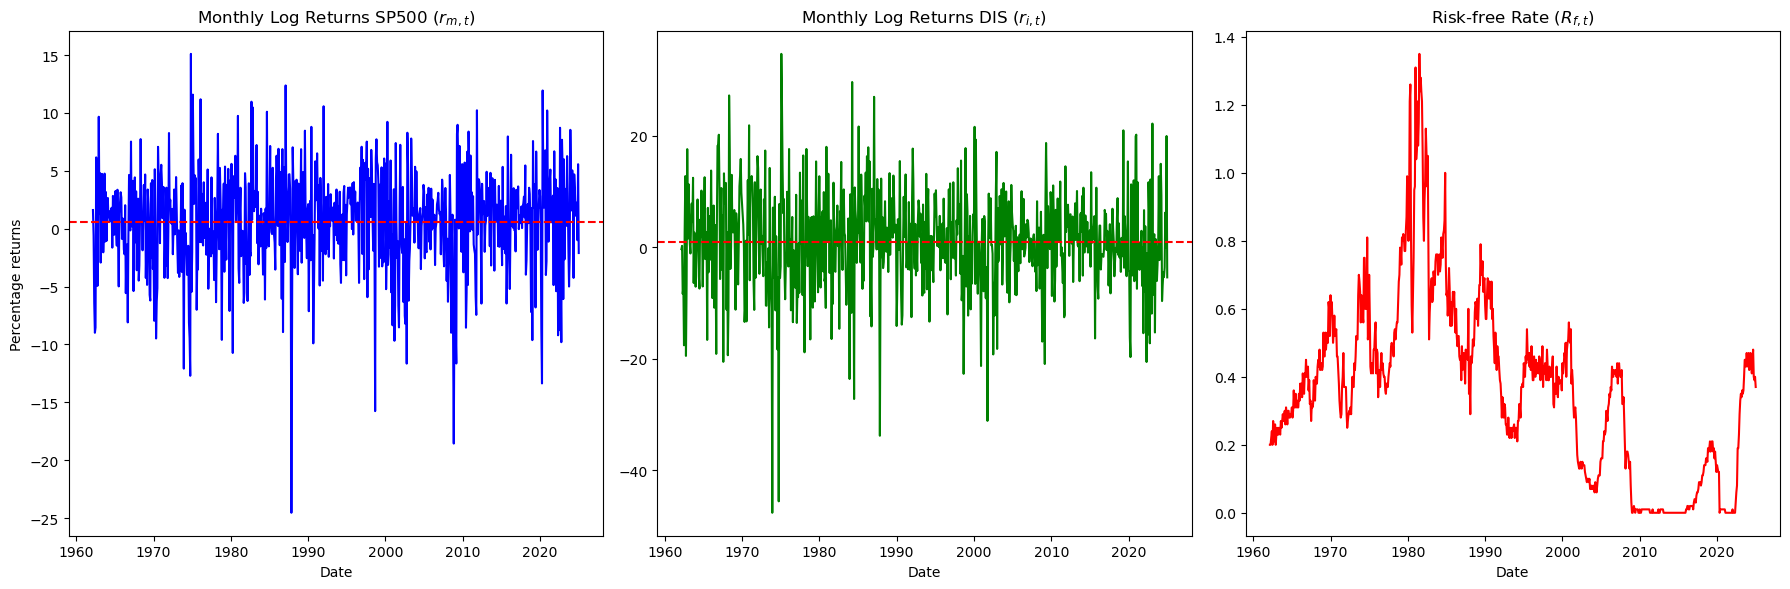

In [279]:
# Create a plot summary of ticker, SP500, and RF return

# Transform date range for time series plotting
dates_monthly = rt_fct_m.index.to_timestamp(how='end')

# Define plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# SP500
axs[0].plot(dates_monthly, rt_fct_m['SP500'], linestyle='-', marker='', color='blue')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Percentage returns')
axs[0].set_title('Monthly Log Returns SP500 ($r_{m,t}$)')
axs[0].axhline(y=rt_fct_m['SP500'].mean(), color="red",linestyle='dashed', linewidth=1.5)

# Ticker
axs[1].plot(dates_monthly, rt_fct_m[TICKER], linestyle='-', marker='', color='green')
axs[1].set_xlabel('Date')
axs[1].set_title(f'Monthly Log Returns {TICKER} ($r_{{i,t}}$)')
axs[1].axhline(y=rt_fct_m[TICKER].mean(), color="red",linestyle='dashed', linewidth=1.5)

# Risk-free Rate
axs[2].plot(dates_monthly, rt_fct_m['RF'], linestyle='-', marker='', color='red')
axs[2].set_xlabel('Date')
axs[2].set_title('Risk-free Rate ($R_{f,t}$)')

plt.tight_layout()
plt.show()

In [280]:
# Create descriptive table 2

# Define log returns sources
rt_fct_m_adj = rt_fct_m[[TICKER, 'SP500', 'CRSP VW', 'RF']]

# Create statistics computation function
def statistics_B(x):
    stat_tab = {
        'Mean': round(np.mean(x),5),
        'St.Deviation': round(np.std(x, ddof=1),5),
        'Skewness': round(skew(x),5),
        'Kurtosis': round(kurtosis(x),5),
        'Excess.Kurtosis': round(kurtosis(x) - 3, 5),
        'Min': round(np.min(x),5),
        'Quant.5%': round(np.quantile(x, 0.05),5),
        'Quant.25%': round(np.quantile(x, 0.25),5),
        'Median': round(np.quantile(x, 0.50),5),
        'Quant.75%': round(np.quantile(x, 0.75),5),
        'Quant.95%': round(np.quantile(x, 0.95),5),
        'Max': round(np.max(x),5),
        'LjBox.lag1.pval.x100': acorr_ljungbox(x, lags=[1], boxpierce=False).values[0][1] * 100,
        'LjBox.lag10.pval.x100': acorr_ljungbox(x, lags=[12], boxpierce=False).values[0][1] * 100,
        'Jarque.Bera.pval.X100': round(jarque_bera(x)[1] * 100,5),
        'Lillie.test.pval.X100': round(lilliefors(x)[1] * 100,5),
        'N.obs': len(x)
    }
    return stat_tab

STATS_M = pd.DataFrame({key: statistics_B(data) for key, data in rt_fct_m_adj.items()})

STATS_M

,DIS,SP500,CRSP VW,RF
Mean,1.000500,0.589680,0.937170,3.607000e-01
St.Deviation,8.903020,4.348420,4.480390,2.613800e-01
Skewness,-0.463070,-0.656710,-0.472900,6.868500e-01
Kurtosis,2.671500,2.206180,1.643170,7.986200e-01
Excess.Kurtosis,-0.328500,-0.793820,-1.356830,-2.201380e+00
Min,-47.672730,-24.542800,-22.590000,0.000000e+00
Quant.5%,-13.415380,-7.114090,-7.139000,0.000000e+00
Quant.25%,-3.973820,-1.793850,-1.730000,1.500000e-01
Median,1.363210,0.978360,1.280000,3.700000e-01
Quant.75%,6.017030,3.440650,3.805000,4.900000e-01


In [281]:
"""
All returns and factor values are in x100
"""

'\nAll returns and factor values are in x100\n'

#### Model 1: Capital Asset Pricing Model (CAPM)

In [282]:
# STEP 1: Linear regression of the CAPM model

# Dependant variable (Y) - ticker excess return
capm_Y = zt_fct_m[TICKER]

# Independant variable (X) - market excess return
capm_x1 = zt_fct_m["CRSP VW"]

# CAPM Params
capm_params = {
    "X":capm_x1,
    "Y":capm_Y
}

# Add vector of 1 (constant) to compute intercept
capm_X = sm.add_constant(capm_x1)  

# Run the CAPM regression
CAPM = sm.OLS(capm_Y, capm_X).fit()

# Retreive CAPM residuals and squared residuals
capm_resid = CAPM.resid
capm_resid_sqrd = np.power(capm_resid, 2)
capm_resid.name, capm_resid_sqrd.name = 'CAPM.resid', 'CAPM.resid.sqrd'


def describe_capm_coeff(res):
    # Data
    alpha, beta = res.params
    a_pval, b_pval = res.pvalues
    rsq = res.rsquared
    
    # Printing
    print(f"• Alpha: is equal to {round(alpha, 2)} and is{'' if a_pval < 0.05 else ' not'} significantly different from 0, which is{'' if a_pval > 0.05 else  ' not'} consistent with CAPM predictions that alpha is equal to 0.")
    print(f"• Beta: is equal to {round(beta, 2)} and is{'' if b_pval < 0.05 else ' not'} significant, which is{'' if b_pval < 0.05 else ' not'} consistent with CAPM predictions that the asset return is proportional to its beta.")
    print(f"• R2 is equal to {round(rsq, 4)}, indicating that {round(rsq * 100, 2)}% of the asset variance is explained by the market factor (according to the linear model). Idiosyncratic risk is {round((1- rsq) * 100, 2)}%.")

# Print Result
print(CAPM.summary())
print(f"\n----- CAPM Regression Coefficient Interpretation -----\n")
describe_capm_coeff(CAPM)

                            OLS Regression Results                            
Dep. Variable:                    DIS   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     489.5
Date:                Thu, 06 Nov 2025   Prob (F-statistic):           5.92e-84
Time:                        13:26:42   Log-Likelihood:                -2533.0
No. Observations:                 755   AIC:                             5070.
Df Residuals:                     753   BIC:                             5079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0776      0.255     -0.305      0.7

Misspecification CAPM:

In [283]:
"""
On misspecification: check CH2 p.93 !!!
"""

'\nOn misspecification: check CH2 p.93 !!!\n'

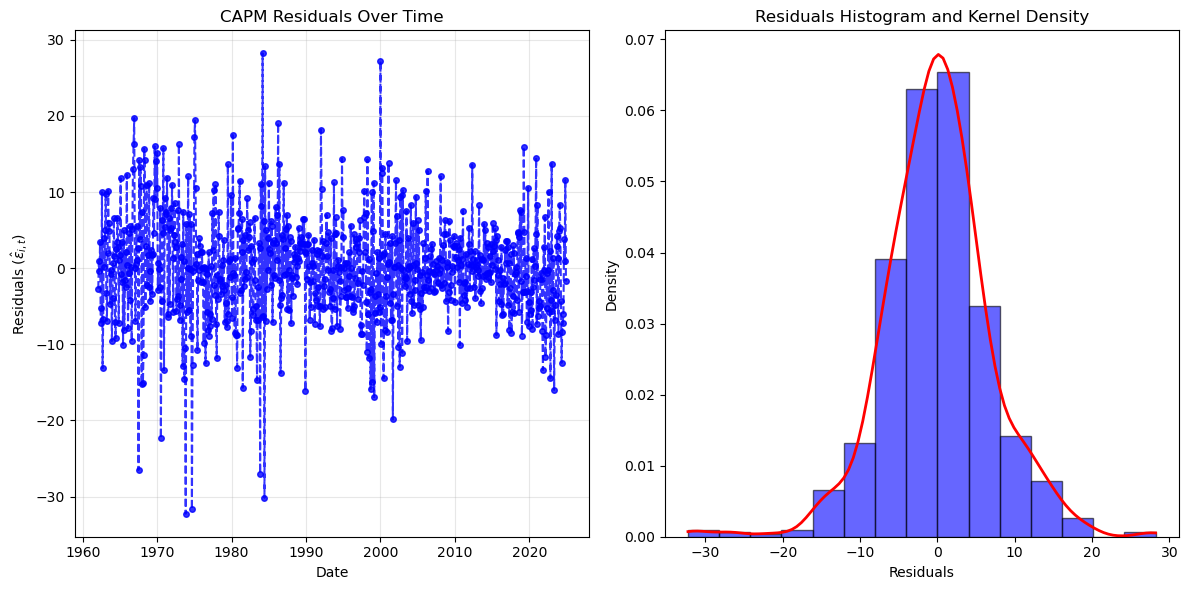

In [284]:
# Step 2: misspecification of the LRM

# TEST 0: Graphical representation

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Residuals over time
axes[0].plot(capm_Y.index.to_timestamp(), capm_resid, 'o--', markersize=4, color='blue', alpha=0.8)
axes[0].set_title('CAPM Residuals Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Residuals ($\\hat{\\epsilon}_{i,t}$)')
axes[0].grid(alpha=0.3)

# Histogram + kernel
axes[1].hist(capm_resid, bins=15, density=True, alpha=0.6, color='b', edgecolor='black',label='Histogram')
axes[1].plot(np.linspace(min(capm_resid), max(capm_resid), 100), gaussian_kde(capm_resid)(np.linspace(min(capm_resid), max(capm_resid), 100)), 'r', linewidth=2, label='Kernel Density')
axes[1].set_title("Residuals Histogram and Kernel Density")
axes[1].set_xlabel("Residuals")
axes[1].set_ylabel("Density")

plt.tight_layout()
plt.show()

H0: The residuals (ε) are homoscedastic 
H1: The residuals (ε) are heteroscedastic
-----
Stats       15.859285
p-value      0.000360
f-value      8.067599
f-pvalue     0.000341
dtype: float64
-----
Reject the null hypothesis, residuals are likely heteroscedastic (pval = 0.0004)


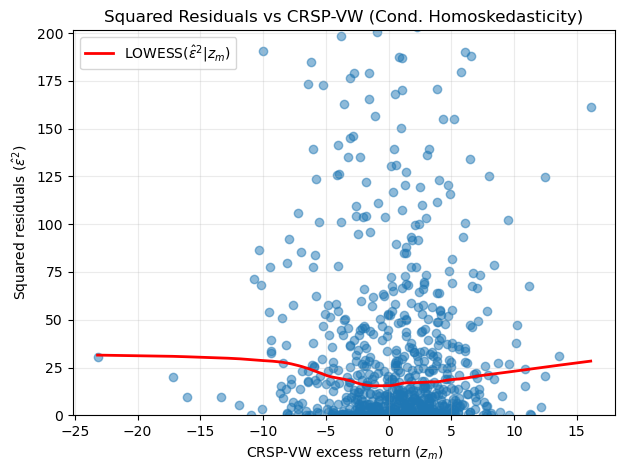

In [285]:
# TEST 1: White test for homoscedasticity of CAPM monthly residuals

# Compute White test
m_white_results = het_white(capm_resid, capm_X)

# Create a series to store results 
M_WT = pd.Series(m_white_results, index=['Stats', 'p-value', 'f-value', 'f-pvalue'])

# Print Results
print(f"H0: The residuals (ε) are homoscedastic \nH1: The residuals (ε) are heteroscedastic\n-----\n{M_WT}\n-----")

if M_WT['p-value'] > 0.05:
    print(f"Fail to reject the null hypothesis, residuals are likely homoscedastic (pval = {M_WT['p-value']:.4f})")
    print("* Consequently, OLS standard errors are biased")
else:
        print(f"Reject the null hypothesis, residuals are likely heteroscedastic (pval = {M_WT['p-value']:.4f})")


# Graphical representation
# Lowess function for local regression
m_resid2_lowess = lowess(capm_resid_sqrd, capm_x1, frac=0.5, return_sorted=True)

# Plot squared residuals vs market factor
plt.figure(figsize=(7, 5))
plt.scatter(capm_x1, capm_resid_sqrd, alpha=0.5)
plt.plot(m_resid2_lowess[:, 0], m_resid2_lowess[:, 1], lw=2, color='red', label='LOWESS($\hat{\epsilon}^2 | z_m$)')
# Add vertical limit to enhance visualisation
plt.ylim(0, capm_resid_sqrd.quantile(0.95))
plt.xlabel('CRSP-VW excess return ($z_m$)')
plt.ylabel('Squared residuals ($\hat{\epsilon}^2$)')
plt.title('Squared Residuals vs CRSP-VW (Cond. Homoskedasticity)')
plt.legend()
plt.grid(alpha=0.25)
plt.show()

In [286]:
"""
White test includes non-linear relation
“To visualize conditional homoskedasticity, squared residuals were plotted against the market excess return, together with a LOWESS smoother. 
The curve is nearly flat, with a slight U-shaped pattern, indicating that residual variance is mostly constant across market levels, 
though it tends to increase for extreme market movements. 
This visual evidence is consistent with the White test results, suggesting weak or moderate conditional heteroskedasticity.”

Note; The idiosyncratic risk of the asset tends to be higher in both bullish and bearish market conditions, suggesting asymmetric responses to market movements.
"""

'\nWhite test includes non-linear relation\n“To visualize conditional homoskedasticity, squared residuals were plotted against the market excess return, together with a LOWESS smoother. \nThe curve is nearly flat, with a slight U-shaped pattern, indicating that residual variance is mostly constant across market levels, \nthough it tends to increase for extreme market movements. \nThis visual evidence is consistent with the White test results, suggesting weak or moderate conditional heteroskedasticity.”\n\nNote; The idiosyncratic risk of the asset tends to be higher in both bullish and bearish market conditions, suggesting asymmetric responses to market movements.\n'

H0: No autocorrelation up to lag p
H1: One autocorrelation or more up to lag p
-----
Stats       23.113923
p-value      0.026774
f-value      1.950146
f-pvalue     0.026118
dtype: float64
-----
Reject the null hypothesis, residuals exhibit autocorrelation up to lag 12 (pval = 0.0268)
* Consequently, OLS standard errors are biased


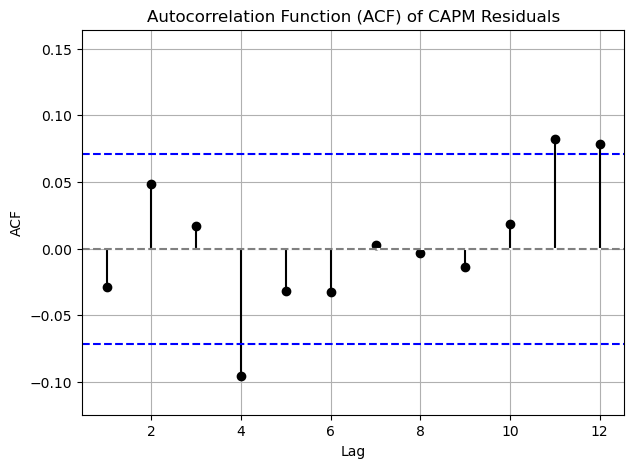

In [287]:
# TEST 2: Breusch-Godfrey test for autocorrelation of CAPM monthly residuals

# Define 1 year of lags
lags_bg = 12

# Run the Breusch-Godfrey test
m_bg_results = acorr_breusch_godfrey(CAPM, nlags=lags_bg)

# Create a series to store results 
M_BG = pd.Series(m_bg_results, index=['Stats', 'p-value', 'f-value', 'f-pvalue'])

# Print results
print(f"H0: No autocorrelation up to lag p\nH1: One autocorrelation or more up to lag p\n-----\n{M_BG}\n-----")

if M_BG['p-value'] > 0.05:
    print(f"Fail to reject the null hypothesis, no residuals autocorrelation detected up to lag {lags_bg} (pval = {M_BG['p-value']:.4f})")
else:
    print(f"Reject the null hypothesis, residuals exhibit autocorrelation up to lag {lags_bg} (pval = {M_BG['p-value']:.4f})")
    print("* Consequently, OLS standard errors are biased")

# Compute ACF function and confidence interval
m_res_acf = acf(capm_resid, nlags=lags_bg)[1:]
confint = 1.96 / np.sqrt(len(capm_resid))
        
# Plot the ACF Function                 
plt.figure(figsize=(7, 5))
plt.stem(range(1, len(m_res_acf) + 1), m_res_acf, linefmt='k-', markerfmt='ko', basefmt='w-', label = "ACF")
plt.axhline(y=confint, color='blue', linestyle='dashed', label='C.I.')
plt.axhline(y=-confint, color='blue', linestyle='dashed')
plt.axhline(y=0, color='gray', linestyle='--')
plt.ylim(m_res_acf.min() * 1.3, m_res_acf.max() * 2)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF) of CAPM Residuals')
plt.grid(True)
plt.show()

CAPM Residuals
Skew: -0.2093 | Kurtosis: 2.4341
-----
Jarque-Bera Test:
H0: Skew = 0 and Kurt = 3 (normality of skewness and tails)
H1: Skew ≠ 0 and/or Kurt ≠ 3 (non-normality of skewness and tails)
-----
JB         1.918952e+02
p-value    2.140398e-42
dtype: float64
-----
Reject the null hypothesis, the residuals skewness and/or tails are significantly different from those of a normal distribution.


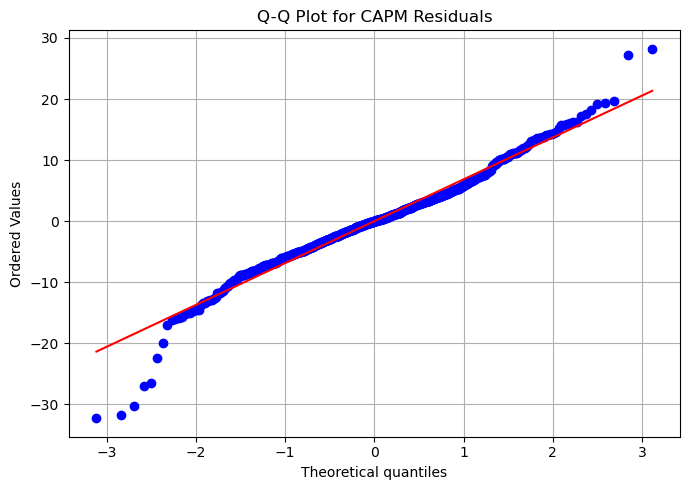

In [288]:
# Test 3: Jarque-Bera test for normality of residuals

# Compute CAPM residuals skew and kurtosis
capm_resid_skew = skew(capm_resid)
capm_resid_kurt = kurtosis(capm_resid)

# Jarque-Bera test to check for skewness and kurtosis
m_jarque_bera_results = stats.jarque_bera(capm_resid)

# Create a series
M_JB = pd.Series({
    "JB": round(m_jarque_bera_results[0], 4),
    "p-value": m_jarque_bera_results[1]
})

# Print results
print(f"CAPM Residuals\nSkew: {round(capm_resid_skew,4)} | Kurtosis: {round(capm_resid_kurt, 4)}\n-----")
print(f"Jarque-Bera Test:\nH0: Skew = 0 and Kurt = 3 (normality of skewness and tails)\nH1: Skew ≠ 0 and/or Kurt ≠ 3 (non-normality of skewness and tails)\n-----\n{M_JB}\n-----")

if M_JB["p-value"] > 0.05:
    print("Fail to reject the null hypothesis, the residuals skewness and tails are not significantly different from those of a normal distribution.")
else : 
    print("Reject the null hypothesis, the residuals skewness and/or tails are significantly different from those of a normal distribution.")
    
# Plot the Q-Q of the residuals vs normal
plt.figure(figsize=(7, 5))
stats.probplot(capm_resid, dist="norm", plot=plt)
plt.title("Q-Q Plot for CAPM Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

In [289]:
# Test 4: Ramsay reset test for linearity and correct specification

# Define if F-test or Chi-square test
m_is_FTest = M_WT['p-value'] > 0.05

# Compute Ramsay results
m_reset_results = linear_reset(CAPM, power=2, use_f=m_is_FTest)

# Create a series
M_RESET = pd.Series([m_reset_results.statistic, m_reset_results.pvalue], index=['Statistic', 'p-value'])

# Print results
print(f"H0: Model is correctly specified (linear and complete)\nH1: Model is misspecified (non-linearities or omitted variables)\n-----\n{M_RESET}\n-----")

if M_RESET['p-value'] < 0.05:
    print(f"Reject the null hypothesis, the model is likely misspecified and CAPM may omit relevant factors.")
else:
    print(f"Fail to reject the null hypothesis, CAPM linear specification appears to be valid.")

H0: Model is correctly specified (linear and complete)
H1: Model is misspecified (non-linearities or omitted variables)
-----
Statistic    2.734992
p-value      0.098172
dtype: float64
-----
Fail to reject the null hypothesis, CAPM linear specification appears to be valid.


In [290]:
"""
The Ramsey RESET test evaluates whether non-linear combinations of the fitted values improve the model’s explanatory power.
At the 5% significance level, the test fails to reject the null hypothesis of correct specification, suggesting that the CAPM regression is adequately specified and no major non-linearities or omitted factors are detected
We don't use f_value=True since heteroscedasticity.
The Ramsey RESET test is used to verify the correct specification of the model and indirectly assess assumption A2 (exogeneity), which states that the residuals have zero conditional mean given the regressors.
Since the Fama–French factors (MKT, SMB, HML) are exogenous by construction and derived from aggregated market portfolios, there is no economic reason to suspect correlation between the factors and the idiosyncratic residuals.
Therefore, the RESET test provides a sufficient and reliable check that no non-linear or omitted functional form of the regressors remains correlated with the residuals.
"""

"\nThe Ramsey RESET test evaluates whether non-linear combinations of the fitted values improve the model’s explanatory power.\nAt the 5% significance level, the test fails to reject the null hypothesis of correct specification, suggesting that the CAPM regression is adequately specified and no major non-linearities or omitted factors are detected\nWe don't use f_value=True since heteroscedasticity.\nThe Ramsey RESET test is used to verify the correct specification of the model and indirectly assess assumption A2 (exogeneity), which states that the residuals have zero conditional mean given the regressors.\nSince the Fama–French factors (MKT, SMB, HML) are exogenous by construction and derived from aggregated market portfolios, there is no economic reason to suspect correlation between the factors and the idiosyncratic residuals.\nTherefore, the RESET test provides a sufficient and reliable check that no non-linear or omitted functional form of the regressors remains correlated with th

"""Les coefficients ont été estimés par OLS. Les tests de White et de Breusch–Godfrey ont révélé la présence d’hétéroscédasticité et d’autocorrélation. Par conséquent, nous rapportons les erreurs-types corrigées selon la méthode de Newey–West (HAC). Cette correction n’affecte pas les estimateurs des coefficients, mais rend leurs écarts-types, t-statistiques et p-values robustes à ces violations. L’utilisation de HAC est standard dans la littérature empirique en finance (voir Newey & West, 1987) pour garantir une inférence valide en présence d’effets de dépendance temporelle ou de variance non constante des résidus.

To understand, see CH2 - P.28

HAC below only modifies the SE of both coefficient, not the other tests, etc. Pour cela qu'on ajoute que la colonne de résultats"""

Compute adjustment

In [380]:
# STEP 3: Compute Newey-West "Heteroskedasticity and autocorrelation-consistent" OLS to 
# obtain robust standard error, max lag of 3 shows short term correlation

# Compute the HAC results from standard OLS
CAPM_HAC = CAPM.get_robustcov_results(cov_type='HAC', maxlags=lags_bg)

def describe_capm_coeff(res):
    # Data
    alpha, beta = res.params
    a_pval, b_pval = res.pvalues
    rsq = res.rsquared
    
    # Printing
    print(f"• Alpha: is equal to {round(alpha, 2)} and is{'' if a_pval < 0.05 else ' not'} significantly different from 0, which is{'' if a_pval > 0.05 else  ' not'} consistent with CAPM predictions that alpha is equal to 0.")
    print(f"• Beta: is equal to {round(beta, 2)} and is{'' if b_pval < 0.05 else ' not'} significant, which is{'' if b_pval < 0.05 else ' not'} consistent with CAPM predictions that the asset return is proportional to its beta.")
    print(f"• R2 is equal to {round(rsq, 4)}, indicating that {round(rsq * 100, 2)}% of the asset variance is explained by the market factor (according to the linear model). Idiosyncratic risk is {round((1- rsq) * 100, 2)}%.")

# Print Result
print(CAPM_HAC.summary())
print(f"\n----- CAPM Adj. Regression Coefficient Interpretation -----\n")
describe_capm_coeff(CAPM_HAC)



                            OLS Regression Results                            
Dep. Variable:                    DIS   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     285.3
Date:                Thu, 06 Nov 2025   Prob (F-statistic):           1.65e-54
Time:                        16:05:43   Log-Likelihood:                -2533.0
No. Observations:                 755   AIC:                             5070.
Df Residuals:                     753   BIC:                             5079.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0776      0.249     -0.311      0.7

In [292]:
"""
To address potential heteroskedasticity and autocorrelation in the residuals, we re-estimated the standard errors using the Newey–West (HAC) correction.
While this estimator does not require normally distributed residuals, it relies on asymptotic normality of the coefficient estimates under the central limit theorem.

The HAC covariance estimator remains consistent under general forms of conditional heteroskedasticity and serial correlation, provided the error process has finite second moments and weak dependence. The resulting t-statistics are asymptotically standard normal.
"""

'\nTo address potential heteroskedasticity and autocorrelation in the residuals, we re-estimated the standard errors using the Newey–West (HAC) correction.\nWhile this estimator does not require normally distributed residuals, it relies on asymptotic normality of the coefficient estimates under the central limit theorem.\n\nThe HAC covariance estimator remains consistent under general forms of conditional heteroskedasticity and serial correlation, provided the error process has finite second moments and weak dependence. The resulting t-statistics are asymptotically standard normal.\n'

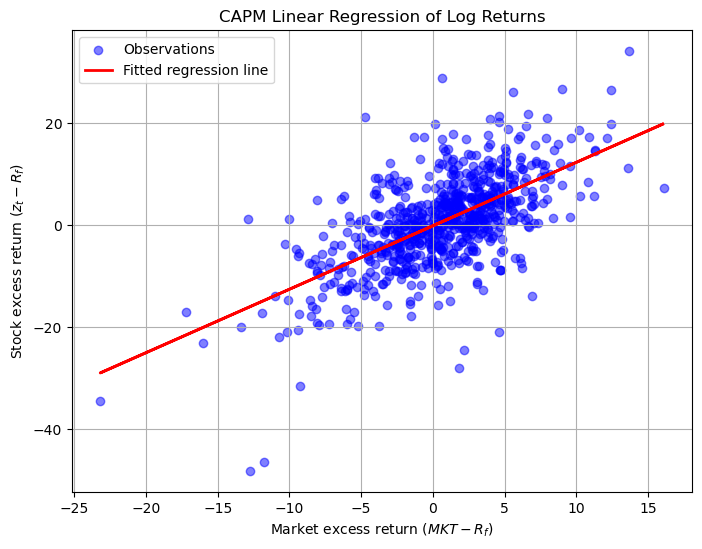

In [293]:
# Step 4: Plot the fitted regression line

# Define X and Y series for regression
capm_xreg = np.linspace(capm_x1.min(), capm_x1.max(), 2)
capm_yreg = CAPM.predict(capm_X)

# Create regression plot
plt.figure(figsize=(8,6))
plt.scatter(capm_x1, capm_Y, label='Observations', color='blue', marker='o', alpha=0.5)
plt.plot(capm_x1, capm_yreg, color='red', lw=2, label='Fitted regression line')
plt.xlabel('Market excess return ($MKT - R_f$)')
plt.ylabel('Stock excess return ($z_t - R_f$)')

plt.title('CAPM Linear Regression of Log Returns')
plt.legend()
plt.grid(True)
plt.show()

----- Regression Coefficients Stability (60-month window) -----

           St.Dev  Coeff.Var
alpha    1.030893  22.178923
CRSP VW  0.280513   0.230640
-----


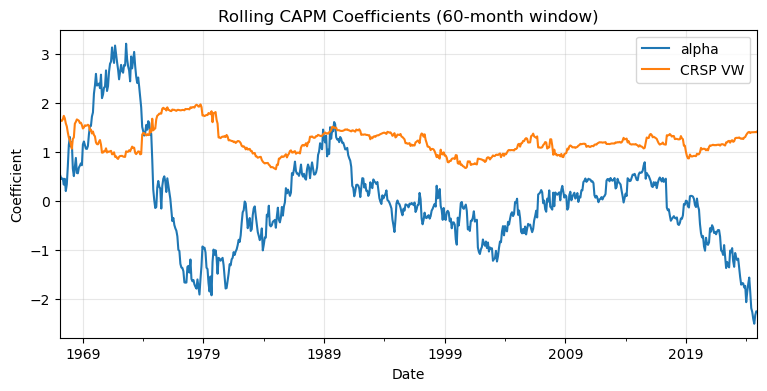

In [ ]:
# Step 5: Complementary analysis
# Analysis 1: Coefficients stability

# Rolling window params for 5 years
m_rlg_window = 60
m_n_window = len(capm_X) - m_rlg_window

# Create a numpy matrix for rolling results
m_roll60_mat = np.zeros((m_n_window, len(capm_X.columns)))

# Loop through the windos
for i in range(m_n_window):
    # Define local slice of X and Y
    sub_y = capm_Y.iloc[i:i+m_rlg_window]
    sub_x = capm_X.iloc[i:i+m_rlg_window]
    # Compute the local regression
    model = sm.OLS(sub_y, sub_x).fit()
    m_roll60_mat[i, :] = model.params.values

# Create a dataframe with the results
m_roll60_coeffs = pd.DataFrame(m_roll60_mat, columns=["alpha", "CRSP VW"], index=capm_X.index[m_rlg_window:])

M_RL60_COEF = pd.DataFrame({
    "St.Dev": m_roll60_coeffs.std(ddof=0),
    "Coeff.Var": m_roll60_coeffs.std(ddof=0) / m_roll60_coeffs.mean().abs()
}, index=m_roll60_coeffs.columns)

print(f'----- Regression Coefficients Stability (60-month window) -----\n\n{M_RL60_COEF}\n-----')


# Create plot
plt.figure(figsize=(9, 4))
m_roll60_coeffs.plot(ax=plt.gca(), linewidth=1.5)
plt.title(f'Rolling CAPM Coefficients ({m_rlg_window}-month window)')
plt.xlabel('Date'); plt.ylabel('Coefficient')
plt.legend(loc='best'); plt.grid(alpha=0.3)
plt.show()

In [ ]:
"""
The coefficient of variation (CV) measures the relative volatility of each factor loading over time, standardizing the dispersion by its mean.
The market beta exhibits a very low CV (≈0.05), indicating stable exposure to market risk, while the SMB and HML betas show higher CVs (≈0.3–0.8), suggesting that size and value exposures fluctuate substantially across market regimes
"""

#### Model 2: Fama-French 3-Factors Model (FF3)

In [294]:
# Adjust excess monthly returns
zt_fct_m_adj = zt_fct_m[[TICKER, 'CRSP VW', 'SMB', 'HML']]

# Compute factors descriptive statistics
STATS_F = pd.DataFrame({key: statistics_B(data) for key, data in zt_fct_m_adj.items()})

STATS_F

,DIS,CRSP VW,SMB,HML
Mean,0.639800,0.576460,0.142330,0.294950
St.Deviation,8.908940,4.493540,3.014030,2.948490
Skewness,-0.480740,-0.484340,0.426440,0.085140
Kurtosis,2.711640,1.637500,4.797620,2.279050
Excess.Kurtosis,-0.288360,-1.362500,1.797620,-0.720950
Min,-48.232730,-23.190000,-17.410000,-13.830000
Quant.5%,-13.906380,-7.349000,-4.173000,-4.096000
Quant.25%,-4.345590,-2.005000,-1.725000,-1.385000
Median,1.036250,1.010000,0.080000,0.230000
Quant.75%,5.682830,3.435000,1.935000,1.730000


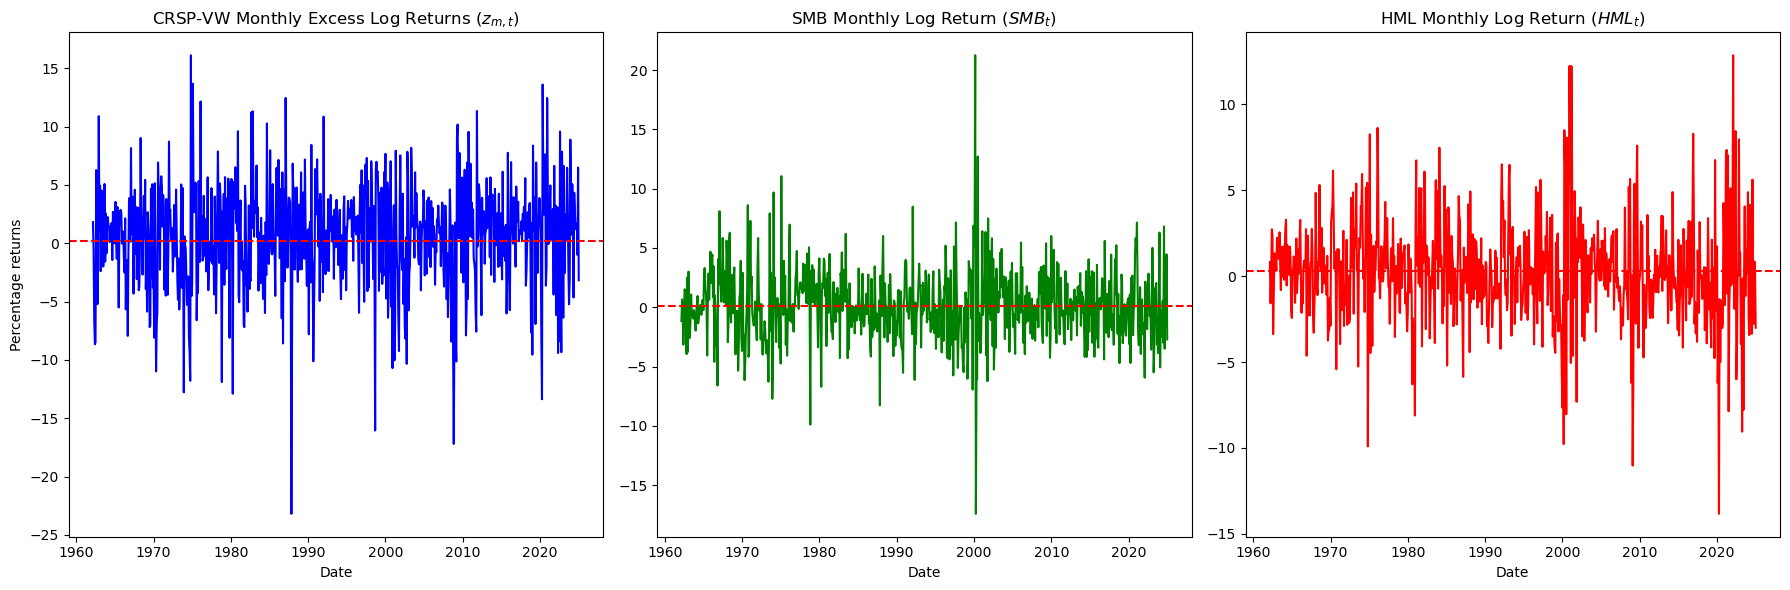

In [295]:
# Create a plot summary of ticker, and fama french factors

# Define plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# SP500
axs[0].plot(dates_monthly, zt_fct_m['CRSP VW'], linestyle='-', marker='', color='blue')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Percentage returns')
axs[0].set_title('CRSP-VW Monthly Excess Log Returns ($z_{m,t}$)')
axs[0].axhline(y=zt_fct_m['SP500'].mean(), color="red",linestyle='dashed', linewidth=1.5)

# Ticker
axs[1].plot(dates_monthly, zt_fct_m["SMB"], linestyle='-', marker='', color='green')
axs[1].set_xlabel('Date')
axs[1].set_title('SMB Monthly Log Return ($SMB_t$)')
axs[1].axhline(y=zt_fct_m["SMB"].mean(), color="red",linestyle='dashed', linewidth=1.5)

# Risk-free Rate
axs[2].plot(dates_monthly, zt_fct_m["HML"], linestyle='-', marker='', color='red')
axs[2].set_xlabel('Date')
axs[2].set_title('HML Monthly Log Return ($HML_t$)')
axs[2].axhline(y=zt_fct_m["HML"].mean(), color="red",linestyle='dashed', linewidth=1.5)


plt.tight_layout()
plt.show()

In [383]:
# STEP 1: Multi-linear regression of ticker on the french factors

# Dependant variable (Y) - ticker excess return
ff3_Y = zt_fct_m[TICKER]

# Independant variable (X) - market excess return
MKT = zt_fct_m["CRSP VW"]
SMB = zt_fct_m["SMB"]
HML = zt_fct_m["HML"]

# CAPM Params
ff3_params = {
    "X1":MKT,
    "X2": SMB,
    "X3": HML,
    "Y": ff3_Y
}

# Create a table with the factors only
ff3_Xs = pd.DataFrame({"CRSP-VW": MKT, "SMB": SMB, "HML": HML})

# Add vector of 1 (constant) to compute intercept
ff3_X = sm.add_constant(ff3_Xs)

# Run the CAPM regression
FF3 = sm.OLS(ff3_Y, ff3_X).fit()

# Retreive CAPM residuals
ff3_resid = FF3.resid
ff3_resid_sqrd = np.power(FF3.resid,2)
ff3_resid.name, ff3_resid_sqrd.name = 'FF3.resid', 'FF3.resid.sqrd'

# Print results
def describe_ff3_coeff(res):
    # Data
    a, bm, bs, bh = res.params
    pa, pM, pS, pH = res.pvalues
    rsq, rsq_adj = res.rsquared, res.rsquared_adj

    # Printing
    print(f"• Alpha: {a:.2f} ({'significant' if pa<0.05 else 'not significant'}, p={pa:.3f}) — {'indicating abnormal return unexplained by the 3 factors' if pa<0.05 else 'consistent with Fama–French predictions (no abnormal return)'}.")
    print(f"• Market beta (βₘ): {bm:.2f} ({'significant' if pM<0.05 else 'not significant'}, p={pM:.3f}) — {'the asset is sensitive to the market factor movements' if pM<0.05 else 'weak link to market factor'}.")
    print(f"• SMB loading (βₛ): {bs:.2f} ({'significant' if pS<0.05 else 'not significant'}, p={pS:.3f}) — {'small-cap exposure' if bs>0 and pS<0.05 else 'large-cap characteristics' if bs<0 and pS<0.05 else 'limited sensitivity to size factor'}.")
    print(f"• HML loading (βₕ): {bh:.2f} ({'significant' if pH<0.05 else 'not significant'}, p={pH:.3f}) — {'value-style exposure (high book-to-market)' if bh>0 and pH<0.05 else 'growth-style exposure (low book-to-market)' if bh<0 and pH<0.05 else 'little sensitivity to the value factor'}.")
    print(f"• Adj. R2: {rsq_adj:.4f} — model explains {rsq*100:.2f}% of excess return variance.")

# Print Result
print(FF3.summary())
print(f"\n----- FF3 Regression Coefficient Interpretation -----\n")
describe_ff3_coeff(FF3)

                            OLS Regression Results                            
Dep. Variable:                    DIS   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     163.7
Date:                Thu, 06 Nov 2025   Prob (F-statistic):           1.18e-81
Time:                        16:44:59   Log-Likelihood:                -2532.1
No. Observations:                 755   AIC:                             5072.
Df Residuals:                     751   BIC:                             5091.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1138      0.257     -0.443      0.6

Misspecification test:

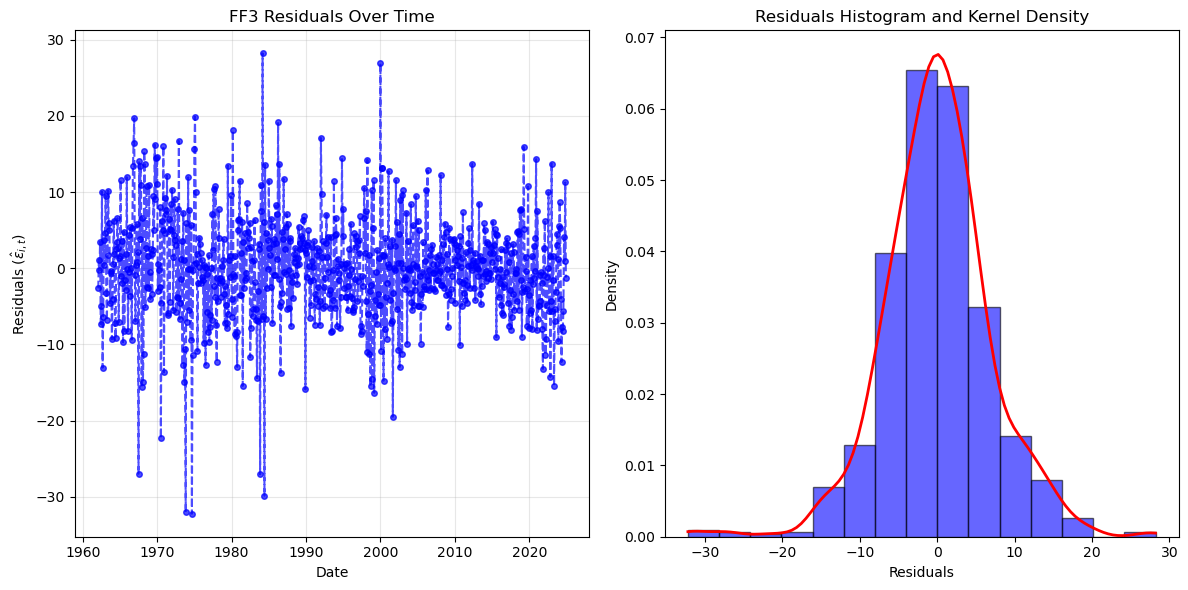

In [297]:
# Step 2: misspecification of the MLRM

# TEST 0: Graphical representation

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Residuals over time
axes[0].plot(ff3_Y.index.to_timestamp(), ff3_resid, 'o--', markersize=4, color='blue', alpha=0.7)
axes[0].set_title('FF3 Residuals Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Residuals ($\\hat{\\epsilon}_{i,t}$)')
axes[0].grid(alpha=0.3)

# Histogram + kernel
axes[1].hist(ff3_resid, bins=15, density=True, alpha=0.6, color='b', edgecolor='black',label='Histogram')
axes[1].plot(np.linspace(min(ff3_resid), max(ff3_resid), 100), gaussian_kde(ff3_resid)(np.linspace(min(ff3_resid), max(ff3_resid), 100)), 'r', linewidth=2, label='Kernel Density')
axes[1].set_title("Residuals Histogram and Kernel Density")
axes[1].set_xlabel("Residuals")
axes[1].set_ylabel("Density")

plt.tight_layout()
plt.show()

In [298]:
# Test 1: Variance inflation factor (VIF) for multicollinearity

# Compute VIF for each factors
f_vif_results = [variance_inflation_factor(ff3_Xs.values, t) for t in range(len(ff3_Xs.columns))]

# Create a series from result
F_VIF = pd.Series(f_vif_results, index=[ff3_Xs.columns])
F_VIF.name = 'FF3.VIF'

# Print results
def describe_vif(res):
    if (res < 2).all():
        return "Multicollinearity of exogene variables is negligable, variables are nearly orthogonal"
    elif (res < 5).all():
        return "Multicollinearity of exogene variables is low but to consider, t-stats might be slightly inflated"
    else:
         return "Multicollinearity of exogene variables is strong, t-stats are inflated and hardly interpretable"
   
print(f"----- VIF (Multicollinearity) -----\n{F_VIF}\n-----")
print(describe_vif(F_VIF))

----- VIF (Multicollinearity) -----
CRSP-VW    1.125770
SMB        1.106614
HML        1.044974
Name: FF3.VIF, dtype: float64
-----
Multicollinearity of exogene variables is negligable, variables are nearly orthogonal


In [299]:
"""Variance Inflation Factors (VIF) are close to 1 for all regressors (MKT = 1.13, SMB = 1.11, HML = 1.04), indicating that the three Fama–French factors are nearly orthogonal in this sample."""

'Variance Inflation Factors (VIF) are close to 1 for all regressors (MKT = 1.13, SMB = 1.11, HML = 1.04), indicating that the three Fama–French factors are nearly orthogonal in this sample.'

H0: The residuals (ε) are homoscedastic 
H1: The residuals (ε) are heteroscedastic
-----
Stats       29.177342
p-value      0.000605
f-value      3.327584
f-pvalue     0.000534
dtype: float64
-----
Reject the null hypothesis, residuals are likely heteroscedastic (pval = 0.0006)


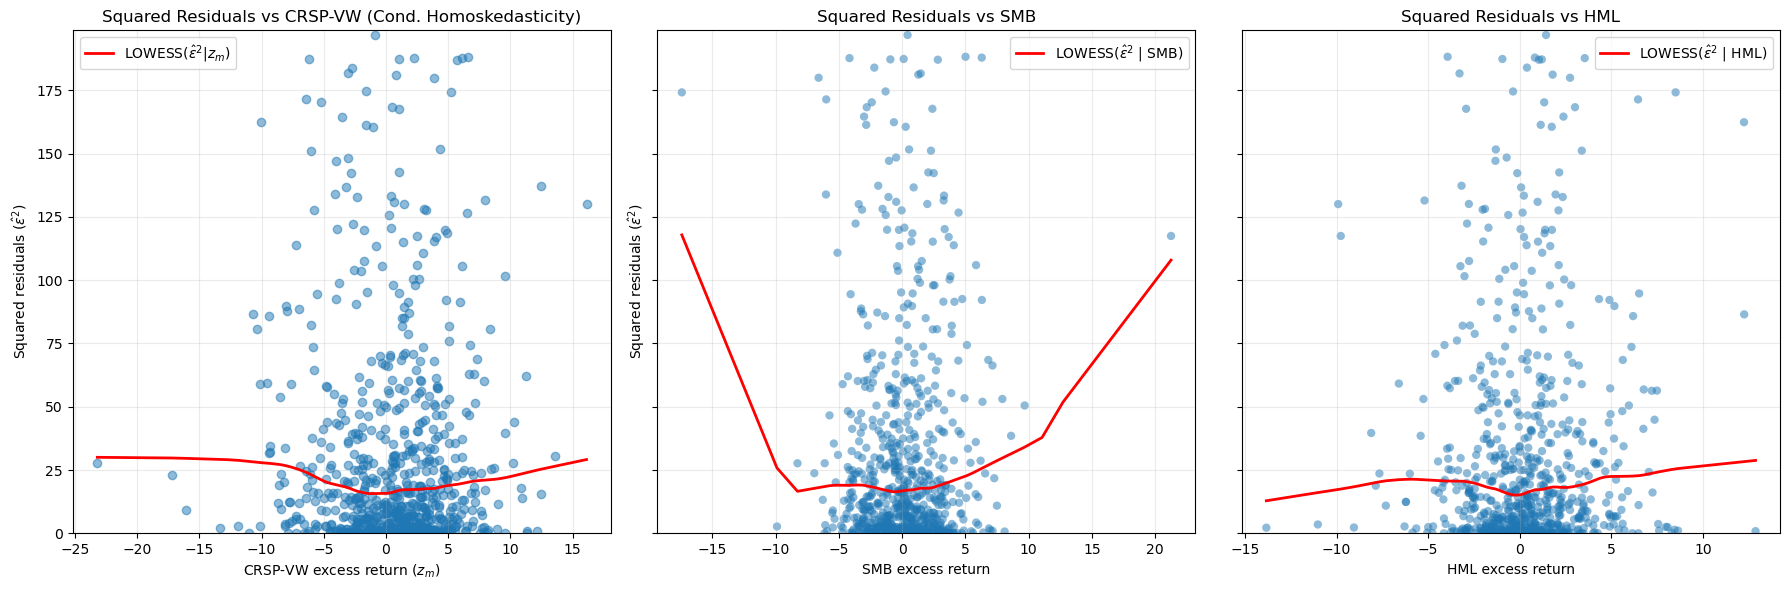

In [300]:
# TEST 2: White test for homoscedasticity of CAPM monthly residuals

# Compute White test
f_white_results = het_white(ff3_resid, ff3_X)

# Create a series to store results 
F_WT = pd.Series(f_white_results, index=['Stats', 'p-value', 'f-value', 'f-pvalue'])

# Print Results
print(f"H0: The residuals (ε) are homoscedastic \nH1: The residuals (ε) are heteroscedastic\n-----\n{F_WT}\n-----")

if F_WT['p-value'] > 0.05:
    print(f"Fail to reject the null hypothesis, residuals are likely homoscedastic (pval = {F_WT['p-value']:.4f})")
    print("* Consequently, OLS standard errors are biased")
else:
        print(f"Reject the null hypothesis, residuals are likely heteroscedastic (pval = {F_WT['p-value']:.4f})")

# Graphical representation

# Creating subplot
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# MKT factorr
f_resid2_lowess_mkt = lowess(ff3_resid_sqrd, MKT, frac=0.5, return_sorted=True)
axs[0].scatter(MKT, ff3_resid_sqrd, alpha=0.5)
axs[0].plot(f_resid2_lowess_mkt[:, 0], f_resid2_lowess_mkt[:, 1], lw=2, color='red', label='LOWESS($\hat{\epsilon}^2 | z_m$)')
axs[0].set_ylim(0, ff3_resid_sqrd.quantile(0.95))
axs[0].set_xlabel('CRSP-VW excess return ($z_m$)')
axs[0].set_ylabel('Squared residuals ($\hat{\epsilon}^2$)')
axs[0].set_title('Squared Residuals vs CRSP-VW (Cond. Homoskedasticity)')
axs[0].legend()
axs[0].grid(alpha=0.25)

# SMB factor
f_resid2_lowess_smb = lowess(ff3_resid_sqrd, SMB, frac=0.5, return_sorted=True)
axs[1].scatter(SMB, ff3_resid_sqrd, alpha=0.5, edgecolor='none')
axs[1].plot(f_resid2_lowess_smb[:, 0], f_resid2_lowess_smb[:, 1], color='red', lw=2, label='LOWESS($\hat{\epsilon}^2$ | SMB)')
axs[1].set_ylim(0, ff3_resid_sqrd.quantile(0.95))
axs[1].set_xlabel('SMB excess return')
axs[1].set_ylabel('Squared residuals ($\hat{\epsilon}^2$)')
axs[1].set_title('Squared Residuals vs SMB')
axs[1].grid(alpha=0.25)
axs[1].legend()

# HML factor
f_resid2_lowess_hml = lowess(ff3_resid_sqrd, HML, frac=0.5, return_sorted=True)
axs[2].scatter(HML, ff3_resid_sqrd, alpha=0.5, edgecolor='none')
axs[2].plot(f_resid2_lowess_hml[:, 0], f_resid2_lowess_hml[:, 1], color='red', lw=2, label='LOWESS($\hat{\epsilon}^2$ | HML)')
axs[2].set_ylim(0, ff3_resid_sqrd.quantile(0.95))
axs[2].set_xlabel('HML excess return')
axs[2].set_title('Squared Residuals vs HML')
axs[2].grid(alpha=0.25)
axs[2].legend()

# Show
plt.tight_layout()
plt.show()

H0: No autocorrelation up to lag p
H1: One autocorrelation or more up to lag p
-----
Stats       22.239569
p-value      0.034921
f-value      1.869079
f-pvalue     0.034872
dtype: float64
-----
Reject the null hypothesis, residuals exhibit autocorrelation up to lag 12 (pval = 0.0349)
* Consequently, OLS standard errors are biased


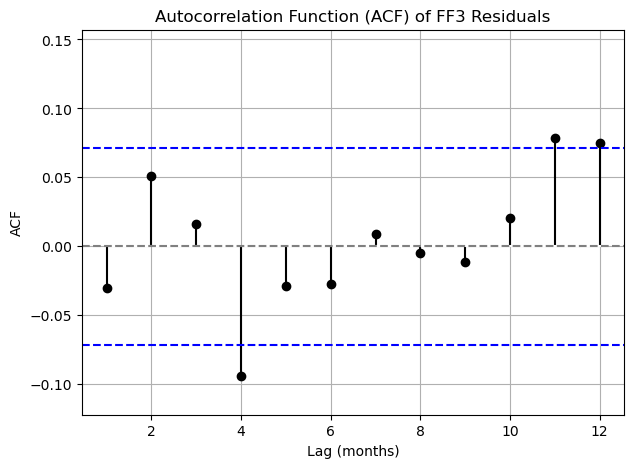

In [301]:
# TEST 3: Breusch-Godfrey test for autocorrelation of FF3 monthly residuals

# Define 1 year of lags
lags_bg = 12

# Run the Breusch-Godfrey test
f_bg_results = acorr_breusch_godfrey(FF3, nlags=lags_bg)

# Create a series to store results 
F_BG = pd.Series(f_bg_results, index=['Stats', 'p-value', 'f-value', 'f-pvalue'])

# Print results
print(f"H0: No autocorrelation up to lag p\nH1: One autocorrelation or more up to lag p\n-----\n{F_BG}\n-----")

if F_BG['p-value'] > 0.05:
    print(f"Fail to reject the null hypothesis, no residuals autocorrelation detected up to lag {lags_bg} (pval = {F_BG['p-value']:.4f})")
else:
    print(f"Reject the null hypothesis, residuals exhibit autocorrelation up to lag {lags_bg} (pval = {F_BG['p-value']:.4f})")
    print("* Consequently, OLS standard errors are biased")

# Compute ACF function and confidence interval
f_res_acf = acf(ff3_resid, nlags=lags_bg)[1:]
confint = 1.96 / np.sqrt(len(ff3_resid))
        
# Plot the ACF Function                 
plt.figure(figsize=(7, 5))
plt.stem(range(1, len(f_res_acf) + 1), f_res_acf, linefmt='k-', markerfmt='ko', basefmt='w-', label = "ACF")
plt.axhline(y=confint, color='blue', linestyle='dashed', label='C.I.')
plt.axhline(y=-confint, color='blue', linestyle='dashed')
plt.axhline(y=0, color='gray', linestyle='--')
plt.ylim(f_res_acf.min() * 1.3, f_res_acf.max() * 2)
plt.xlabel('Lag (months)')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF) of FF3 Residuals')
plt.grid(True)
plt.show()

Fama-French Residuals
Skew: -0.2163 | Kurtosis: 2.4291
-----
Jarque-Bera Test:
H0: Skew = 0 and Kurt = 3 (normality of skewness and tails)
H1: Skew ≠ 0 and/or Kurt ≠ 3 (non-normality of skewness and tails)
-----
JB         1.915110e+02
p-value    2.593715e-42
dtype: float64
-----
Reject the null hypothesis, the residuals skewness and/or tails are significantly different from those of a normal distribution.


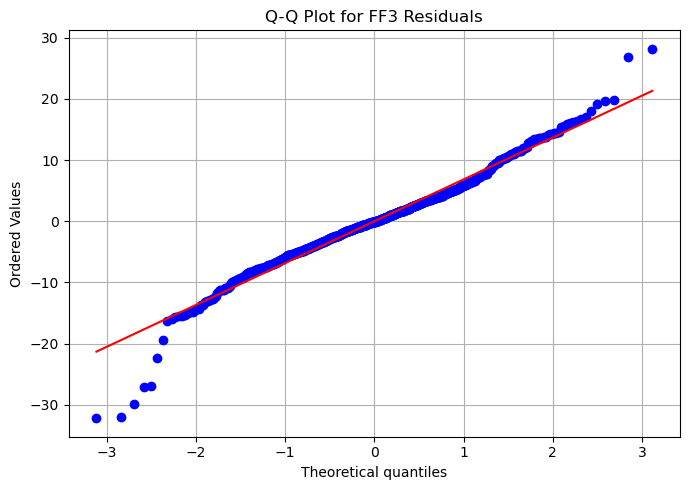

In [302]:
# TEST 4: Jarque-Bera test for normality of residuals

# Compute FF3 residuals skew and kurtosis
ff3_resid_skew = skew(ff3_resid)
ff3_resid_kurt = kurtosis(ff3_resid)

# Jarque-Bera test to check for skewness and kurtosis
f_jarque_bera_results = stats.jarque_bera(ff3_resid)

# Create a series
F_JB = pd.Series({
    "JB": round(f_jarque_bera_results[0], 4),
    "p-value": f_jarque_bera_results[1]
})

# Print results
print(f"Fama-French Residuals\nSkew: {round(ff3_resid_skew,4)} | Kurtosis: {round(ff3_resid_kurt, 4)}\n-----")
print(f"Jarque-Bera Test:\nH0: Skew = 0 and Kurt = 3 (normality of skewness and tails)\nH1: Skew ≠ 0 and/or Kurt ≠ 3 (non-normality of skewness and tails)\n-----\n{F_JB}\n-----")

if F_JB["p-value"] > 0.05:
    print("Fail to reject the null hypothesis, the residuals skewness and tails are not significantly different from those of a normal distribution.")
else : 
    print("Reject the null hypothesis, the residuals skewness and/or tails are significantly different from those of a normal distribution.")
    
# Plot the Q-Q of the residuals vs normal
plt.figure(figsize=(7, 5))
stats.probplot(ff3_resid, dist="norm", plot=plt)
plt.title("Q-Q Plot for FF3 Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

In [457]:
# TEST 5: Ramsay reset test for linearity and correct specification

# Define if F-test or Chi-square test
f_is_FTest = F_WT['p-value'] > 0.05

# Compute Ramsay results
f_reset_results = linear_reset(FF3, power=3, use_f=f_is_FTest)

# Create a series
F_RESET = pd.Series([f_reset_results.statistic, f_reset_results.pvalue], index=['Statistic', 'p-value'])

# Print results
print(f"H0: Model is correctly specified (linear and complete)\nH1: Model is misspecified (non-linearities or omitted variables)\n-----\n{F_RESET}\n-----")

if F_RESET['p-value'] < 0.05:
    print(f"Reject the null hypothesis, the model is likely misspecified and CAPM may omit relevant factors.")
else:
    print(f"Fail to reject the null hypothesis, CAPM linear specification appears to be valid.")

H0: Model is correctly specified (linear and complete)
H1: Model is misspecified (non-linearities or omitted variables)
-----
Statistic    3.266386
p-value      0.195305
dtype: float64
-----
Fail to reject the null hypothesis, CAPM linear specification appears to be valid.


In [382]:
# STEP 3: Compute Newey-West "Heteroskedasticity and autocorrelation-consistent" OLS to 
# obtain robust standard error, max lag of 12 shows short term correlation

# Compute the HAC results from standard OLS
FF3_HAC = FF3.get_robustcov_results(cov_type='HAC', maxlags=lags_bg)

# Print results
def describe_ff3_coeff(res):
    # Data
    a, bm, bs, bh = res.params
    pa, pM, pS, pH = res.pvalues
    rsq, rsq_adj = res.rsquared, res.rsquared_adj

    # Printing
    print(f"• Alpha: {a:.2f} ({'significant' if pa<0.05 else 'not significant'}, p={pa:.3f}) — {'indicating abnormal return unexplained by the 3 factors' if pa<0.05 else 'consistent with Fama–French predictions (no abnormal return)'}.")
    print(f"• Market beta (βₘ): {bm:.2f} ({'significant' if pM<0.05 else 'not significant'}, p={pM:.3f}) — {'the asset is sensitive to the market factor movements' if pM<0.05 else 'weak link to market factor'}.")
    print(f"• SMB loading (βₛ): {bs:.2f} ({'significant' if pS<0.05 else 'not significant'}, p={pS:.3f}) — {'small-cap exposure' if bs>0 and pS<0.05 else 'large-cap characteristics' if bs<0 and pS<0.05 else 'limited sensitivity to size factor'}.")
    print(f"• HML loading (βₕ): {bh:.2f} ({'significant' if pH<0.05 else 'not significant'}, p={pH:.3f}) — {'value-style exposure (high book-to-market)' if bh>0 and pH<0.05 else 'growth-style exposure (low book-to-market)' if bh<0 and pH<0.05 else 'little sensitivity to the value factor'}.")
    print(f"• Adj. R2: {rsq_adj:.4f} — model explains {rsq*100:.2f}% of excess return variance.")


# Print Result
print(FF3_HAC.summary())
print(f"\n----- FF3 Adj. Regression Coefficient Interpretation -----\n")
describe_ff3_coeff(FF3_HAC)

                            OLS Regression Results                            
Dep. Variable:                    DIS   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     111.3
Date:                Thu, 06 Nov 2025   Prob (F-statistic):           1.19e-59
Time:                        16:44:48   Log-Likelihood:                -2532.1
No. Observations:                 755   AIC:                             5072.
Df Residuals:                     751   BIC:                             5091.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1138      0.258     -0.441      0.6

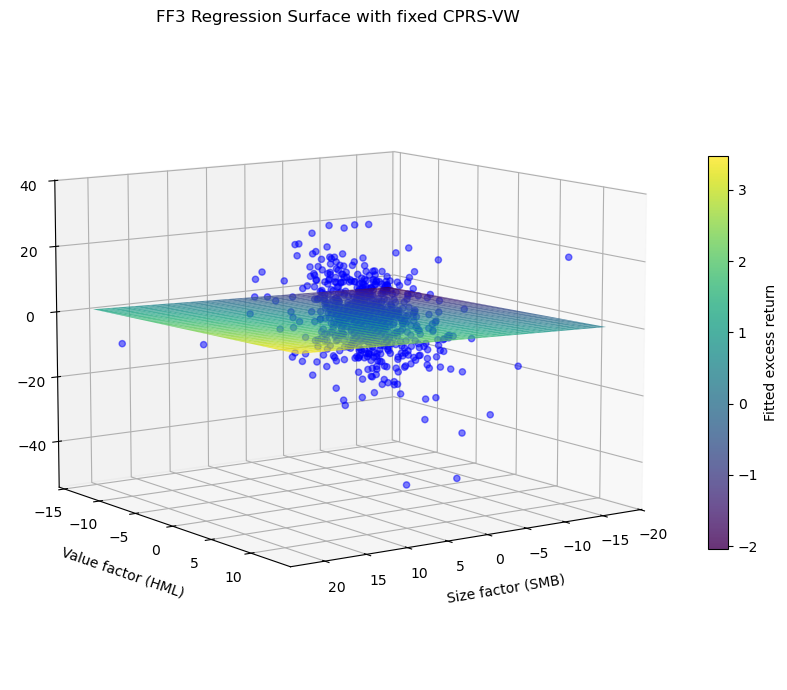

In [305]:
# Step 4: Regression surface with fixed MKT factor

# Axes range and grid
f_smb_range = np.linspace(SMB.min(), SMB.max(), 40)
f_hml_range = np.linspace(HML.min(), HML.max(), 40)
f_SMB_grid, f_HML_grid = np.meshgrid(f_smb_range, f_hml_range)

# Fitted regression surface with fixed MKT
f_fitted_plane = (FF3.params["const"]
               + FF3.params["CRSP-VW"] * MKT.mean()
               + FF3.params["SMB"] * f_SMB_grid
               + FF3.params["HML"] * f_HML_grid)

# Init graphical representation
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

# Observation scatter plotting
ax.scatter(SMB, HML, ff3_Y, color='blue', alpha=0.5, label='Observed returns')

# Compute fitted surface and plot
f_surface = ax.plot_surface(f_SMB_grid, f_HML_grid, f_fitted_plane, cmap='viridis', edgecolor='none', alpha=0.8)
fig.colorbar(f_surface, ax=ax, shrink=0.6, pad=0.05, label='Fitted excess return')

# Plot
ax.set_xlabel('Size factor (SMB)', labelpad=10)
ax.set_ylabel('Value factor (HML)', labelpad=10)
ax.set_zlabel('Excess return (Y)', labelpad=10)
ax.set_title('FF3 Regression Surface with fixed CPRS-VW', pad=0)
ax.grid(alpha=0.3)
ax.view_init(elev=10, azim=55)
plt.tight_layout()
plt.show()

In [464]:
# Step 5: Complementary analysis
# Analysis 1: Additional factors impact (SMB, HML)

# Run joint Wald test for SMB and HML
f_wald_results = FF3.wald_test('SMB = 0, HML = 0', scalar=True)

# Create series
F_WALD = pd.Series([f_wald_results.statistic, f_wald_results.pvalue], index=["Stats", "p-value"])

# Print results
print(f"H0: The additional factors have no significant joint explanatory power\nH1: At least one of the additional factors contributes significantly to the model\n-----\n{F_WALD}\n-----")

if F_WALD['p-value'] < 0.05:
    print("Reject the null hypothesis, the additionnal factors (SMB and HML) jointly add significant explanatory power")
    print("* Supports the use of the Fama–French 3-Factor model over the CAPM")
else:
    print("Fail to reject the null hypothesis, the additionnal factors (SMB and HML) do not jointly improve the explanatory power of the model")
    print("* FF3 offers only marginal improvement over the CAPM")

H0: The additional factors have no significant joint explanatory power
H1: At least one of the additional factors contributes significantly to the model
-----
Stats      0.905765
p-value    0.404674
dtype: float64
-----
Fail to reject the null hypothesis, the additionnal factors (SMB and HML) do not jointly improve the explanatory power of the model
* FF3 offers only marginal improvement over the CAPM


In [ ]:
"""
A joint Wald test was conducted on the FF3 model to test the null hypothesis that β_SMB and β_HML are jointly equal to zero (H₀: β_SMB = β_HML = 0).
The test fails to reject the null (p = 0.21), implying that, jointly, the size and value factors do not significantly improve the explanatory power of the model compared to the CAPM.
This suggests that, for this asset, most of the systematic variation is already captured by the market factor alone."""

"""
“Although the estimated coefficients for SMB and HML are nonzero, the joint Wald test fails to reject the null hypothesis that both coefficients are equal to zero.
This implies that the observed effects are not statistically distinguishable from zero, suggesting that the additional factors do not significantly improve the explanatory power of the model.
"""

----- Regression Coefficients Stability (60-month window) -----

           St.Dev  Coeff.Var
alpha    1.096992  16.814927
CRSP VW  0.251972   0.213537
SMB      0.354726   2.929969
HML      0.472261   9.998835
-----


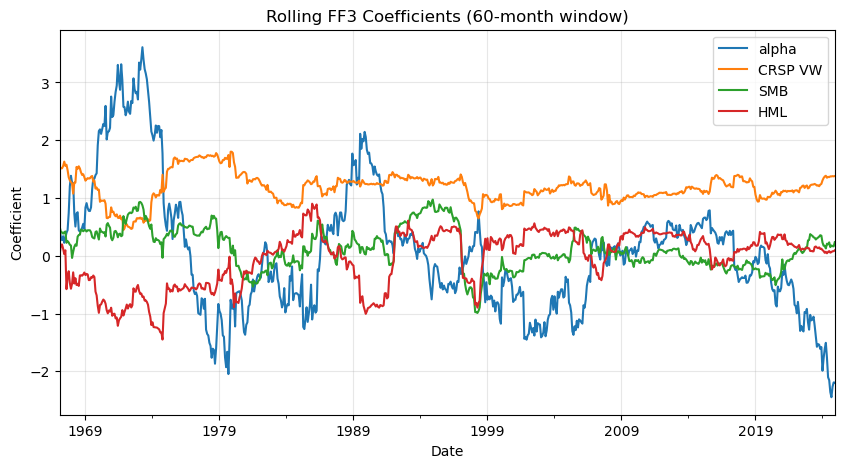

In [ ]:
# Analysis 2: Coefficients stability

# Rolling window params for 5 years
f_rlg_window = 60
f_n_window = len(ff3_X) - f_rlg_window

# Create a numpy matrix for rolling results
f_roll60_mat = np.zeros((f_n_window, len(ff3_X.columns)))

# Loop through the windos
for i in range(f_n_window):
    # Define local slice of X and Y
    sub_y = ff3_Y.iloc[i:i+f_rlg_window]
    sub_x = ff3_X.iloc[i:i+f_rlg_window]
    # Compute the local regression
    model = sm.OLS(sub_y, sub_x).fit()
    f_roll60_mat[i, :] = model.params.values

# Create a dataframe with the results
f_roll60_coeffs = pd.DataFrame(f_roll60_mat, columns=["alpha", "CRSP VW", "SMB", "HML"], index=ff3_X.index[f_rlg_window:])

F_RL60_COEF = pd.DataFrame({
    "St.Dev": f_roll60_coeffs.std(ddof=0),
    "Coeff.Var": f_roll60_coeffs.std(ddof=0) / f_roll60_coeffs.mean().abs()
}, index=f_roll60_coeffs.columns)

print(f'----- Regression Coefficients Stability (60-month window) -----\n\n{F_RL60_COEF}\n-----')


# Create plot
plt.figure(figsize=(10, 5))
f_roll60_coeffs.plot(ax=plt.gca(), linewidth=1.5)
plt.title(f'Rolling FF3 Coefficients ({f_rlg_window}-month window)')
plt.xlabel('Date'); plt.ylabel('Coefficient')
plt.legend(loc='best'); plt.grid(alpha=0.3)
plt.show()

#### 3. Model Comparaison

In [ ]:
# STEP 1: Coefficients

# Table 1

# Create coefficients DataFrame
MODELS_COEF = pd.DataFrame({
    'α': [CAPM_HAC.params[0], FF3_HAC.params[0]],
    '': [CAPM_HAC.pvalues[0], FF3_HAC.pvalues[0]],
    'β_MKT': [CAPM_HAC.params[1], FF3_HAC.params[1]],
    ' ': [CAPM_HAC.pvalues[1], FF3_HAC.pvalues[1]],
    'β_SMB': [np.nan, FF3_HAC.params[2]],
    '  ': [np.nan, FF3_HAC.pvalues[2]],
    'β_HML': [np.nan, FF3_HAC.params[3]],
    '   ': [np.nan, FF3_HAC.pvalues[3]]
}, index=['CAPM', 'FF3']).round(4).T

print("=== Coefficients & Significance (CAPM vs FF3) ===")
MODELS_COEF

=== Coefficients & Significance (CAPM vs FF3) ===


,CAPM,FF3
α,-0.0776,-0.1138
,0.7558,0.6593
β_MKT,1.2444,1.2400
,0.0000,0.0000
β_SMB,NaN,0.0837
,NaN,0.4624
β_HML,NaN,0.0909
,NaN,0.3671


In [492]:
# Step 2: Goodness of fit
# Table 1

# Calculate root mean squared error for CAPM/FF3
capm_rmse = np.sqrt(CAPM_HAC.ssr / CAPM_HAC.df_resid)
ff3_rmse = np.sqrt(FF3_HAC.ssr / FF3_HAC.df_resid)

# Create goodness of fit DataFrame
MODELS_GOF = pd.DataFrame({
    "α": [CAPM_HAC.params[0], FF3_HAC.params[0]],
    "": [CAPM_HAC.pvalues[0], FF3_HAC.pvalues[0]],
    "R2": [CAPM_HAC.rsquared, FF3_HAC.rsquared],
    "Adj. R2": [CAPM_HAC.rsquared_adj, FF3_HAC.rsquared_adj],
    "RMSE": [capm_rmse, ff3_rmse],
}, index=['CAPM', 'FF3']).T

print("=== Goodness of Fit (CAPM vs FF3) ===")
MODELS_GOF

=== Goodness of Fit (CAPM vs FF3) ===


,CAPM,FF3
α,-0.077574,-0.113772
,0.755828,0.659281
R2,0.393976,0.395434
Adj. R2,0.393171,0.393019
RMSE,6.939998,6.940867


In [507]:
# Step 3: Coefficient stability
# Table 1

# Create coefficient stability DataFrame
MODELS_STAB = pd.DataFrame({
    "α": [M_RL60_COEF.loc["alpha", "Coeff.Var"], F_RL60_COEF.loc["alpha", "Coeff.Var"]],
    "β_MKT": [M_RL60_COEF.loc["CRSP VW", "Coeff.Var"], F_RL60_COEF.loc["CRSP VW", "Coeff.Var"]],
    "β_SMB": [np.nan, F_RL60_COEF.loc["SMB", "Coeff.Var"]],
    "β_HML": [np.nan, F_RL60_COEF.loc["HML", "Coeff.Var"]],
}, index= ["CAPM", "FF3"]).round(4).T

print("=== Coefficient Stability (CAPM vs FF3) ===")
MODELS_STAB

=== Coefficient Stability (CAPM vs FF3) ===


,CAPM,FF3
α,22.1789,16.8149
β_MKT,0.2306,0.2135
β_SMB,NaN,2.9300
β_HML,NaN,9.9988


In [ ]:
"""
Coefficients — magnitude and significance.
The market beta is large and precisely estimated in both models (β_MKT ≈ 1.24, p<0.001), implying that a 1 pp move in the market translates into roughly 1.24 pp for the stock’s excess return. In the FF3 specification, the size and value loadings are small and statistically indistinguishable from zero (β_SMB ≈ 0.08, p≈0.46; β_HML ≈ 0.09, p≈0.37), providing no evidence of persistent “small” or “value” tilts for this single stock over the sample. Intercepts are economically small and clearly insignificant in both models (α_CAPM ≈ −0.08, p≈0.76; α_FF3 ≈ −0.11, p≈0.66).

Goodness of fit — model comparison.
The move from CAPM to FF3 yields a negligible change in fit: R² rises only from 0.394 to 0.395, the adjusted R² actually edges down (0.3932 → 0.3930 after penalizing extra factors), and RMSE is essentially unchanged (≈6.94 in both cases). Together with the non-significance of SMB and HML, this indicates that the additional factors do not materially improve the in-sample explanatory power for this asset; most time-series variation is already captured by the market factor.

Economic interpretation — alpha and theory.
Because alphas are not statistically different from zero in either model, the results are consistent with asset-pricing theory: under CAPM, no abnormal return remains after controlling for market risk; under multi-factor views (APT/FF3), adding size and value does not reveal a residual mispricing either. Rolling-window evidence (not shown here) further suggests a stable market exposure, while SMB/HML sensitivities are comparatively more volatile—typical for individual stocks. Overall, for this security and sample, the CAPM provides an adequate description; FF3 adds little beyond a richer but statistically weak decomposition of risk."""